In [ ]:
"""
HEALTHCARE READMISSION ANALYTICS PROJECT
=========================================
Author: Sanjana
Date: Feb 2026
Purpose: End-to-end analysis of hospital readmissions using diabetes patient data

This script demonstrates:
1. Data acquisition from public sources
2. Data preprocessing and cleaning
3. Exploratory data analysis
4. Predictive modeling
5. Results visualization and reporting


"""

In [9]:
# SECTION 1: ENVIRONMENT SETUP AND LIBRARY IMPORTS
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import(
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

#utility libraries
import warnings
import os
from datetime import datetime

#cinfiguration setting
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', 100)  # Display up to 100 rows
plt.style.use('seaborn-v0_8-darkgrid')  # Set consistent plot style

#set random seed reproductivity
np.random.seed(42)

print("=" * 80)
print("HEALTHCARE READMISSION ANALYTICS PROJECT")
print("=" * 80)
print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("All libraries imported successfully!\n")




HEALTHCARE READMISSION ANALYTICS PROJECT
Execution started at: 2026-02-21 17:31:07
All libraries imported successfully!



In [46]:
# SECTION 2: DATA ACQUISITION
"""
We'll download the Diabetes 130-US Hospitals dataset from UCI ML Repository.
This dataset contains 10 years of hospital admission records for diabetes patients.

Dataset characteristics:
- 101,766 hospital admissions
- ~50 features (patient demographics, diagnoses, medications, procedures)
- Target variable: Readmission status
"""
print("\n" + "=" * 80)
print("DATA ACQUISITION")
print("=" * 80)

# Define data URL - UCI Machine Learning Repository
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"

# Alternative manual download instructions
print("""
DATA DOWNLOAD INSTRUCTIONS:
---------------------------
Option 1 (Recommended): Manual Download
1. Visit: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008
2. Click 'Download' to get 'dataset_diabetes.zip'
3. Extract the ZIP file
4. Place 'diabetic_data.csv' in your working directory

Option 2: Direct Download (if accessible)
The script will attempt to download automatically.
""")
# Check if data already exists
data_file = 'dataset_diabetes/diabetic_data.csv'

if os.path.exists(data_file):
    print(f"✓ Data file '{data_file}' found in current directory.")
else:
    print(f"✗ Data file '{data_file}' not found.")
    print("Please download manually following the instructions above.")
    print("\nFor this tutorial, we'll proceed assuming the file is available.")

#load the dataset

try:    
    print('\nLoading Dataset...')
    df_raw=pd.read_csv(data_file)
    print(f"✓ Dataset loaded successfully!")
    print(f" --Shape: {df_raw.shape[0]:,} row *  {df_raw.shape[1]} columns")
    print(f" memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2: 2f} MB")

except FileNotFoundError:
    print("\n⚠ ERROR: Data file not found!")
    print("Creating sample instructions for students...")
    print("\nTo continue with this tutorial:")
    print("1. Download the dataset from the UCI repository")
    print("2. Save 'diabetic_data.csv' in this directory")
    print("3. Re-run this script")

    # Display basic information about the dataset
print("\n" + "-" * 80)
print("INITIAL DATA PREVIEW")
print("-" * 80)
print("\nFirst 5 rows:")
print(df_raw.head())

print("\n\nDataset Info:")
print(df_raw.info())

print("\n\nBasic Statistics:")
print(df_raw.describe())



DATA ACQUISITION

DATA DOWNLOAD INSTRUCTIONS:
---------------------------
Option 1 (Recommended): Manual Download
1. Visit: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008
2. Click 'Download' to get 'dataset_diabetes.zip'
3. Extract the ZIP file
4. Place 'diabetic_data.csv' in your working directory

Option 2: Direct Download (if accessible)
The script will attempt to download automatically.

✓ Data file 'dataset_diabetes/diabetic_data.csv' found in current directory.

Loading Dataset...
✓ Dataset loaded successfully!
 --Shape: 101,766 row *  50 columns
 memory usage:  192.870752 MB

--------------------------------------------------------------------------------
INITIAL DATA PREVIEW
--------------------------------------------------------------------------------

First 5 rows:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     556291



DATA QUALITY ASSESSMENT

1. DUPLICATE RECORDS CHECK
--------------------------------------------------------------------------------
Total duplicate rows: 0

 Columns with missing values: 2

       column  Missing_count  Missing_percentage
max_glu_serum          96420               94.75
    A1Cresult          84748               83.28


3. PLACEHOLDER VALUES CHECK
--------------------------------------------------------------------------------
Healthcare datasets often use '?' or 'Unknown' as placeholders.

Columns with '?' placeholders: 7
  - weight: 98,569 (96.86%)
  - medical_specialty: 49,949 (49.08%)
  - payer_code: 40,256 (39.56%)
  - race: 2,273 (2.23%)
  - diag_3: 1,423 (1.4%)
  - diag_2: 358 (0.35%)
  - diag_1: 21 (0.02%)


4. DATA TYPES SUMMARY
--------------------------------------------------------------------------------
object    37
int64     13
Name: count, dtype: int64


Columns by data type:

int64:
  Count: 13
  Columns: encounter_id, patient_nbr, admission_type_id

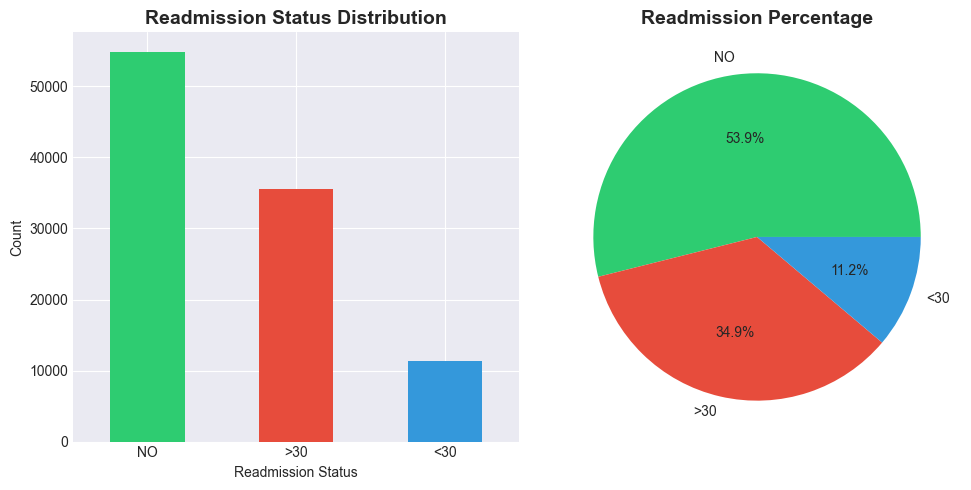

In [45]:
# SECTION 3: DATA QUALITY ASSESSMENT

"""
Before any analysis, we must understand data quality issues:
1. Missing values
2. Duplicate records
3. Data types
4. Value distributions
5. Outliers

This step is CRITICAL - poor data quality leads to poor insights!
"""

print("\n\n" + "=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# Create a copy for preprocessing (preserve raw data)
df = df_raw.copy()

# 3.1 Check for duplicate records
print("\n1. DUPLICATE RECORDS CHECK")
print("-" * 80)
duplicates=df.duplicated().sum()
print(f"Total duplicate rows: {duplicates:,}")

if duplicates > 0:
    print(f"Percentage of duplicates: {duplicates/len(df)*100:.2f}%")
    # Note: We'll keep duplicates as they represent separate encounters
    print("Note: In healthcare, duplicate rows may represent separate patient encounters.")
    print("We'll retain them for now and investigate further.")

#calcumate missing data
missing_data=pd.DataFrame({
    'column': df.columns,
    'Missing_count': df.isnull().sum(),
    'Missing_percentage': (df.isnull().sum()/ len(df) * 100).round(2)
})
missing_data=missing_data[missing_data['Missing_count']>0].sort_values(
    'Missing_percentage', ascending=False
)

if len(missing_data)>0:
    print(f"\n Columns with missing values: {len(missing_data)}")
    print("\n" + missing_data.to_string(index=False))
else:
    print("✓ No missing values detected in the dataset!")

# 3.3 Check for placeholder values (common in healthcare data)
print("\n\n3. PLACEHOLDER VALUES CHECK")
print("-" * 80)
print("Healthcare datasets often use '?' or 'Unknown' as placeholders.")

# Count '?' occurrences in each column
placeholder_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':  # Only check string columns
        placeholder_count = (df[col] == '?').sum()
        if placeholder_count > 0:
            placeholder_counts[col] = {
                'count': placeholder_count,
                'percentage': round(placeholder_count / len(df) * 100, 2)
            }
            
if placeholder_counts:
    print(f"\nColumns with '?' placeholders: {len(placeholder_counts)}")
    for col, stats in sorted(placeholder_counts.items(), 
                            key=lambda x: x[1]['percentage'], 
                            reverse=True):
        print(f"  - {col}: {stats['count']:,} ({stats['percentage']}%)")
else:
    print("✓ No '?' placeholders found!")

# 3.4 Data types examination
print("\n\n4. DATA TYPES SUMMARY")
print("-" * 80)
dtype_summary=df.dtypes.value_counts()
print(dtype_summary)

print("\n\nColumns by data type:")
for dtype in df.dtypes.unique():
    cols=df.select_dtypes(include=[dtype]).columns.tolist()
    print(f"\n{dtype}:")
    print(f"  Count: {len(cols)}")
    print(f"  Columns: {', '.join(cols[:5])}{'...' if len(cols) > 5 else ''}")

# 3.5 Target variable distribution
print("\n\n5. TARGET VARIABLE ANALYSIS")
print("-" * 80)
print("Our target variable is 'readmitted' - indicating if patient was readmitted.")
if 'readmitted' in df.columns:
    print("\nReadmission status distribution:")
    readmit_dist=df['readmitted'].value_counts()
    print(readmit_dist)
    print("\nPercentages:")
    print((readmit_dist/ len (df) * 100).round(2))

    #visualize the target dist
    plt.figure(figsize=(10, 5))

    plt.subplot(1,2,1)
    readmit_dist.plot(kind='bar', color=['#2ecc71', '#e74c3c', '#3498db'])
    plt.title('Readmission Status Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Readmission Status')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    plt.subplot(1, 2, 2)
    plt.pie(readmit_dist.values, labels=readmit_dist.index, autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c', '#3498db'])
    plt.title('Readmission Percentage', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved: '01_target_distribution.png'")
    plt.show()
    



In [49]:
# SECTION 4: DATA CLEANING AND PREPROCESSING

"""
Based on our quality assessment, we'll now clean the data:
1. Handle missing/placeholder values
2. Remove unnecessary columns
3. Convert data types
4. Create binary target variable (for modeling simplification)
"""

print("\n\n" + "=" * 80)
print("DATA CLEANING AND PREPROCESSING")
print("=" * 80)

# 4.1 Replace '?' with NaN for consistent missing value handling
print("\n1. REPLACING PLACEHOLDER VALUES")
print("-" * 80)
df = df.replace('?', np.nan)
print("✓ Replaced all '?' with NaN (proper missing value indicator)")

# 4.2 Drop columns with excessive missing data or low predictive value
print("\n2. REMOVING PROBLEMATIC COLUMNS")
print("-" * 80)

# Columns to drop (based on domain knowledge and missing data analysis)
columns_to_drop = [
    'encounter_id',  # Identifier, not predictive
    'patient_nbr',   # Identifier, not predictive
    'weight',        # 97% missing
    'payer_code',    # 40% missing, many categories
    'medical_specialty',  # 50% missing
]

print(f" dropping {len(columns_to_drop)} columns")
for col in columns_to_drop:
    if col in df.columns:
        missing_pct=(df[col].isnull().sum()/len(df)*100)
        print(f" - {col}: {missing_pct:.1f}% missing")
        df=df.drop(columns=[col])

print(f"\n✓ New dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# 4.3 Handle remaining missing values
print("\n3. HANDLING REMAINING MISSING VALUES")
print("-" * 80)

# For race, gender, diagnosis codes: fill with 'Unknown'
categorical_fill_cols = ['race', 'gender', 'diag_1', 'diag_2', 'diag_3']

for col in categorical_fill_cols:
    if col in df.columns:
        missing_before = df[col].isnull().sum()
        df[col] = df[col].fillna('Unknown')
        print(f"  - {col}: Filled {missing_before:,} missing values with 'Unknown'")

print("✓ Categorical missing values handled")

# 4.4 Create binary target variable
print("\n4. CREATING BINARY TARGET VARIABLE")
print("-" * 80)
print("Converting 3-class target to binary: Readmitted (< 30 days) vs Not Readmitted")

if 'readmitted' in df.columns:
    
    # Map: '<30' -> 1 (High Risk), 'NO' and '>30' -> 0 (Low Risk)
    df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
    

    print("\nMapping:")
    print("  - '<30 days' → 1 (Readmitted - High Risk)")
    print("  - 'NO' or '>30 days' → 0 (Not Readmitted - Low Risk)")
    
    print("\nNew target distribution:")
    print(df['readmitted_binary'].value_counts())
    print("\nPercentages:")
    print((df['readmitted_binary'].value_counts() / len(df) * 100).round(2))
    
    # Calculate class imbalance ratio
    class_counts = df['readmitted_binary'].value_counts()
    imbalance_ratio = class_counts[0] / class_counts[1]
    print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
    print("(This is important for model selection and evaluation)")

    # 4.5 Feature engineering - consolidate diagnosis codes
print("\n5. FEATURE ENGINEERING - DIAGNOSIS GROUPING")
print("-" * 80)
print("ICD-9 diagnosis codes can be grouped into clinically meaningful categories")

def categorize_diagnosis(diag_code):
    """
    Group ICD-9 diagnosis codes into clinical categories
    
    Parameters:
    -----------
    diag_code : str
        ICD-9 diagnosis code
    
    Returns:
    --------
    str : Category name
    """
    if pd.isna(diag_code) or diag_code == 'Unknown':
        return 'Unknown'

    # convert to string and extract numeric part
    diag_str=str(diag_code)

    # Try to extract numeric code
    try:
        if diag_str.startswith('V') or diag_str.startswith('E'):
            return 'other'

        code=float(diag_str)

        # ICD-9 code ranges (simplified)
        if 390 <= code <= 459 or code == 785:
            return 'Circulatory'
        elif 460 <= code <= 519 or code == 786:
            return 'Respiratory'
        elif 520 <= code <= 579 or code == 787:
            return 'Digestive'
        elif 250 <= code < 251:
            return 'Diabetes'
        elif 800 <= code <= 999:
            return 'Injury'
        elif 710 <= code <= 739:
            return 'Musculoskeletal'
        elif 580 <= code <= 629 or code == 788:
            return 'Genitourinary'
        elif 140 <= code <= 239:
            return 'Neoplasms'
        else:
            return 'Other'
    except:
        return 'Other'

    
#apply diagnosis categorization
for diag_col in ['diag_1', 'diag_2', 'diag_3']:
    if diag_col in df.columns:
        new_col_name=f'{diag_col}_category'
        df[new_col_name]=df[diag_col].apply(categorize_diagnosis)
        print(f"✓ Created {new_col_name}")
        print(f"  Categories: {df[new_col_name].value_counts().to_dict()}")
print("\n✓ Feature engineering complete!")

# 4.6 Convert age to numeric (currently in brackets like '[0-10)')
print("\n6. CONVERTING AGE TO NUMERIC")
print("-" * 80)

if 'age' in df.columns:
    print("Age column contains ranges like '[70-80)'. Converting to midpoint values.")
    
    # Define age range mapping
    age_mapping = {
        '[0-10)': 5,
        '[10-20)': 15,
        '[20-30)': 25,
        '[30-40)': 35,
        '[40-50)': 45,
        '[50-60)': 55,
        '[60-70)': 65,
        '[70-80)': 75,
        '[80-90)': 85,
        '[90-100)': 95
    }

    df['age_numeric']=df['age'].map(age_mapping)
    print(f"✓ Created 'age_numeric' column")
    print(f"  Range: {df['age_numeric'].min()} - {df['age_numeric'].max()} years")

print("\n" + "=" * 80)
print("DATA CLEANING COMPLETE!")
print("=" * 80)
print(f"Final dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Ready for exploratory analysis and modeling!")

#save the cleaned dataset
output_file= 'diabetic_data_cleaned.csv'
df.to_csv(output_file,index=False)
print(f"\n✓ Cleaned dataset saved to: '{output_file}'")
        



DATA CLEANING AND PREPROCESSING

1. REPLACING PLACEHOLDER VALUES
--------------------------------------------------------------------------------
✓ Replaced all '?' with NaN (proper missing value indicator)

2. REMOVING PROBLEMATIC COLUMNS
--------------------------------------------------------------------------------
 dropping 5 columns
 - encounter_id: 0.0% missing
 - patient_nbr: 0.0% missing
 - weight: 96.9% missing
 - payer_code: 39.6% missing
 - medical_specialty: 49.1% missing

✓ New dataset shape: 101,766 rows × 45 columns

3. HANDLING REMAINING MISSING VALUES
--------------------------------------------------------------------------------
  - race: Filled 2,273 missing values with 'Unknown'
  - gender: Filled 0 missing values with 'Unknown'
  - diag_1: Filled 21 missing values with 'Unknown'
  - diag_2: Filled 358 missing values with 'Unknown'
  - diag_3: Filled 1,423 missing values with 'Unknown'
✓ Categorical missing values handled

4. CREATING BINARY TARGET VARIABLE
----

In [50]:
# SECTION 5: CLEANED DATA SUMMARY

print("\n\n" + "=" * 80)
print("CLEANED DATASET SUMMARY")
print("=" * 80)


# 5.1 Numeric features summary
print("\n1. NUMERIC FEATURES SUMMARY")
print("-" * 80)
numeric_cols=df.select_dtypes(include=[np.number]).columns.tolist()
print("\nKey numeric features:")
key_numeric = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
               'num_medications', 'number_outpatient', 'number_emergency',
               'number_inpatient', 'number_diagnoses', 'age_numeric']

for col in key_numeric:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Mean: {df[col].mean():.2f}")
        print(f"  Median: {df[col].median():.2f}")
        print(f"  Std Dev: {df[col].std():.2f}")
        print(f"  Range: [{df[col].min()}, {df[col].max()}]")
# 5.2 Categorical features summary
print("\n\n2. CATEGORICAL FEATURES SUMMARY")
print("-" * 80)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Number of categorical features: {len(categorical_cols)}")

print("\nKey categorical features and their unique values:")
key_categorical = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
                   'admission_source_id', 'diag_1_category', 'diabetesMed', 'change']

for col in key_categorical:
    if col in df.columns:
        unique_count=df[col].nunique()
        print(f"\n{col}: {unique_count} unique values")
        if unique_count <= 10:
            print(df[col].value_counts().head())

# 5.3 Data quality final check
print("\n\n3. FINAL DATA QUALITY CHECK")
print("-" * 80)
print(f"Total records: {len(df):,}")
print(f"Total features: {df.shape[1]}")
print(f"\nMissing values remaining:")
remaining_missing = df.isnull().sum().sum()
print(f"  Total: {remaining_missing:,}")

if remaining_missing > 0:
    print(f"  Percentage: {remaining_missing / (df.shape[0] * df.shape[1]) * 100:.4f}%")
else:
    print("  ✓ No missing values!")

print("\n✓ Dataset is clean and ready for analysis!")



CLEANED DATASET SUMMARY

1. NUMERIC FEATURES SUMMARY
--------------------------------------------------------------------------------

Key numeric features:

time_in_hospital:
  Mean: 4.40
  Median: 4.00
  Std Dev: 2.99
  Range: [1, 14]

num_lab_procedures:
  Mean: 43.10
  Median: 44.00
  Std Dev: 19.67
  Range: [1, 132]

num_procedures:
  Mean: 1.34
  Median: 1.00
  Std Dev: 1.71
  Range: [0, 6]

num_medications:
  Mean: 16.02
  Median: 15.00
  Std Dev: 8.13
  Range: [1, 81]

number_outpatient:
  Mean: 0.37
  Median: 0.00
  Std Dev: 1.27
  Range: [0, 42]

number_emergency:
  Mean: 0.20
  Median: 0.00
  Std Dev: 0.93
  Range: [0, 76]

number_inpatient:
  Mean: 0.64
  Median: 0.00
  Std Dev: 1.26
  Range: [0, 21]

number_diagnoses:
  Mean: 7.42
  Median: 8.00
  Std Dev: 1.93
  Range: [1, 16]

age_numeric:
  Mean: 65.97
  Median: 65.00
  Std Dev: 15.94
  Range: [5, 95]


2. CATEGORICAL FEATURES SUMMARY
--------------------------------------------------------------------------------
Num



EXPLORATORY DATA ANALYSIS

1. UNIVARIATE ANALYSIS - NUMERIC FEATURES
--------------------------------------------------------------------------------
✓ Saved: visualizations/02_numeric_distributions.png


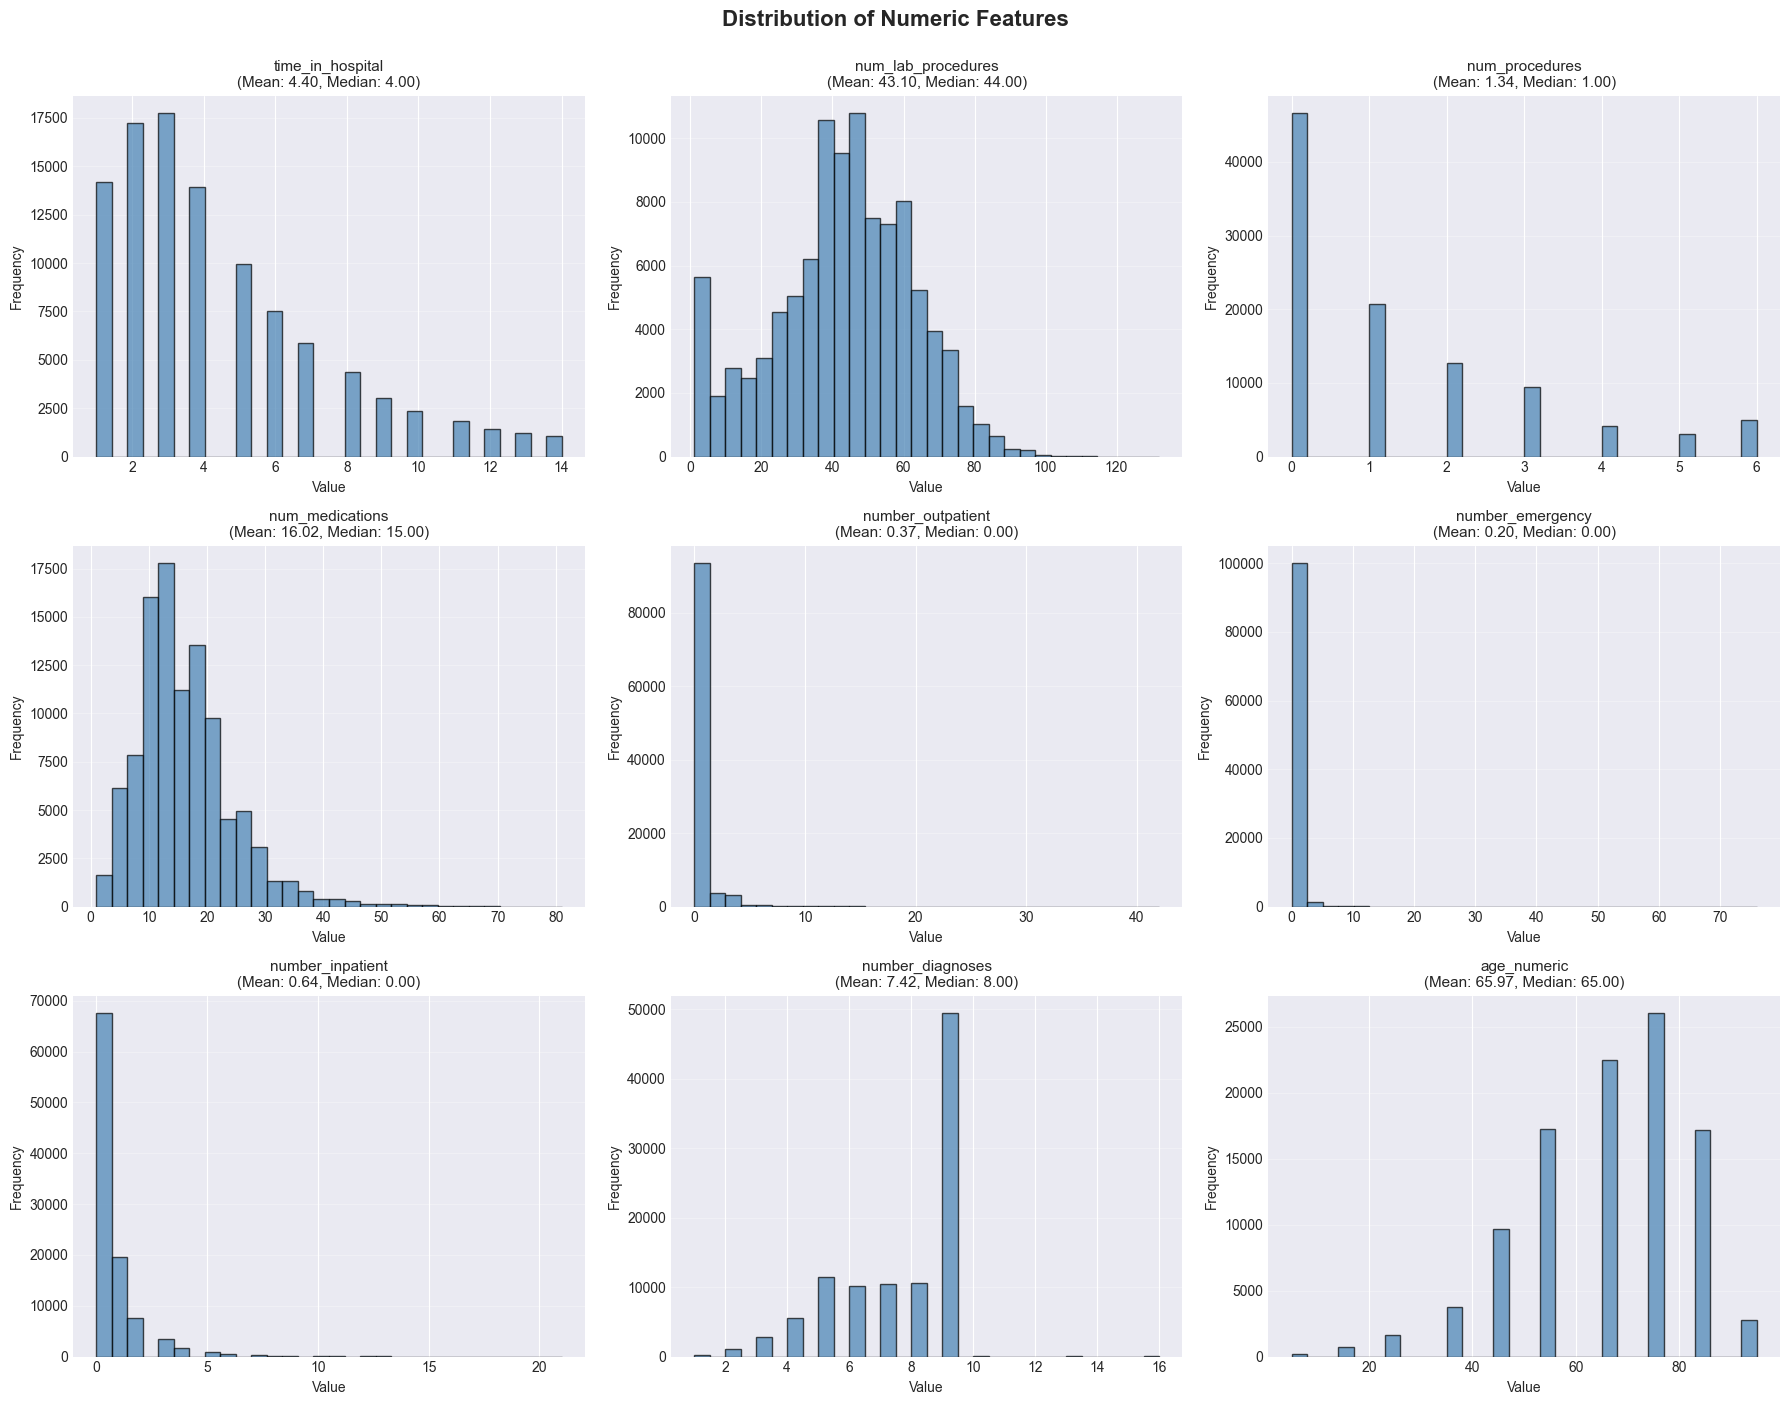


Statistical Summary of Numeric Features:
       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count         101766.00           101766.00       101766.00        101766.00   
mean               4.40               43.10            1.34            16.02   
std                2.99               19.67            1.71             8.13   
min                1.00                1.00            0.00             1.00   
25%                2.00               31.00            0.00            10.00   
50%                4.00               44.00            1.00            15.00   
75%                6.00               57.00            2.00            20.00   
max               14.00              132.00            6.00            81.00   

       number_outpatient  number_emergency  number_inpatient  \
count          101766.00         101766.00         101766.00   
mean                0.37              0.20              0.64   
std                 1.27              0.93   

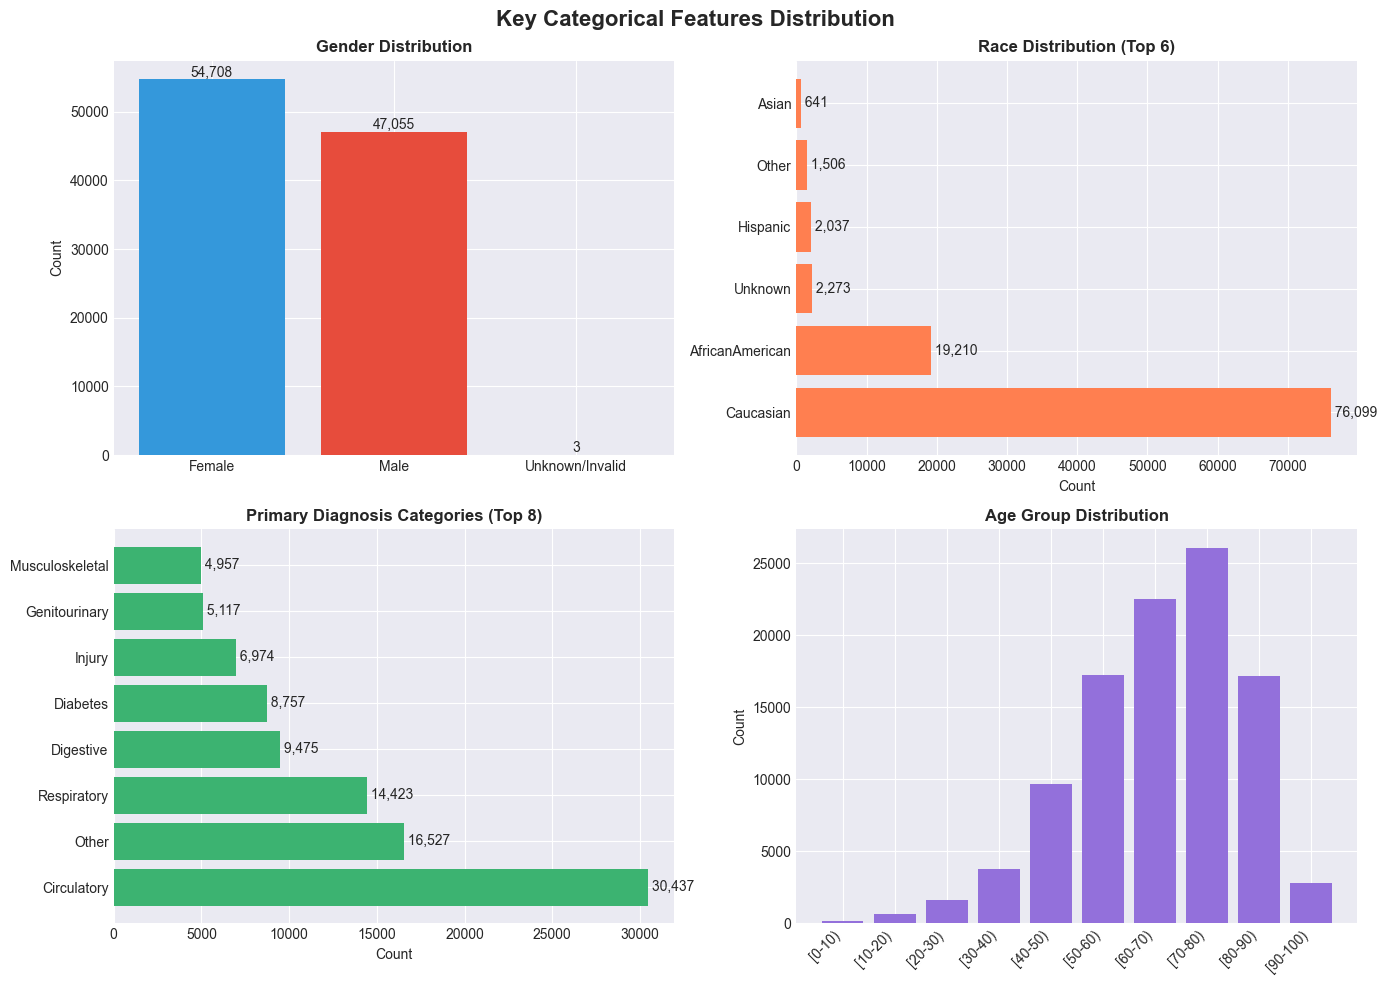

In [51]:
print("\n\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Create output directory for visualizations
import os
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')
    print("✓ Created 'visualizations' directory for output")

# 6.1 UNIVARIATE ANALYSIS - NUMERIC FEATURES
print("\n1. UNIVARIATE ANALYSIS - NUMERIC FEATURES")
print("-" * 80)

# Select key numeric features for analysis
numeric_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                   'num_medications', 'number_outpatient', 'number_emergency',
                   'number_inpatient', 'number_diagnoses', 'age_numeric']

# Create distribution plots
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distribution of Numeric Features', fontsize=16, fontweight='bold', y=1.00)

for idx, col in enumerate(numeric_features):
    if col in df.columns:
        row = idx // 3
        col_idx = idx % 3
        ax = axes[row, col_idx]
        
        # Histogram with KDE
        df[col].hist(bins=30, ax=ax, alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_title(f'{col}\n(Mean: {df[col].mean():.2f}, Median: {df[col].median():.2f})',
                    fontsize=11)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/02_numeric_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/02_numeric_distributions.png")
plt.show()

# Statistical summary
print("\nStatistical Summary of Numeric Features:")
print(df[numeric_features].describe().round(2))

# 6.2 UNIVARIATE ANALYSIS - CATEGORICAL FEATURES
print("\n\n2. UNIVARIATE ANALYSIS - CATEGORICAL FEATURES")
print("-" * 80)

# Gender distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Key Categorical Features Distribution', fontsize=16, fontweight='bold')

# Gender
if 'gender' in df.columns:
    gender_counts = df['gender'].value_counts()
    axes[0, 0].bar(gender_counts.index, gender_counts.values, color=['#3498db', '#e74c3c', '#95a5a6'])
    axes[0, 0].set_title('Gender Distribution', fontweight='bold')
    axes[0, 0].set_ylabel('Count')
    for i, v in enumerate(gender_counts.values):
        axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Race
if 'race' in df.columns:
    race_counts = df['race'].value_counts().head(6)
    axes[0, 1].barh(race_counts.index, race_counts.values, color='coral')
    axes[0, 1].set_title('Race Distribution (Top 6)', fontweight='bold')
    axes[0, 1].set_xlabel('Count')
    for i, v in enumerate(race_counts.values):
        axes[0, 1].text(v, i, f' {v:,}', va='center')

# Primary Diagnosis Category
if 'diag_1_category' in df.columns:
    diag_counts = df['diag_1_category'].value_counts().head(8)
    axes[1, 0].barh(diag_counts.index, diag_counts.values, color='mediumseagreen')
    axes[1, 0].set_title('Primary Diagnosis Categories (Top 8)', fontweight='bold')
    axes[1, 0].set_xlabel('Count')
    for i, v in enumerate(diag_counts.values):
        axes[1, 0].text(v, i, f' {v:,}', va='center')

# Age Distribution
if 'age' in df.columns:
    age_counts = df['age'].value_counts().sort_index()
    axes[1, 1].bar(range(len(age_counts)), age_counts.values, color='mediumpurple')
    axes[1, 1].set_title('Age Group Distribution', fontweight='bold')
    axes[1, 1].set_xticks(range(len(age_counts)))
    axes[1, 1].set_xticklabels(age_counts.index, rotation=45, ha='right')
    axes[1, 1].set_ylabel('Count')




plt.tight_layout()
plt.savefig('visualizations/03_categorical_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/03_categorical_distributions.png")
plt.show()



3. BIVARIATE ANALYSIS - RELATIONSHIP WITH READMISSION
--------------------------------------------------------------------------------

Analyzing numeric features by readmission status...
✓ Saved: visualizations/04_numeric_vs_readmission.png


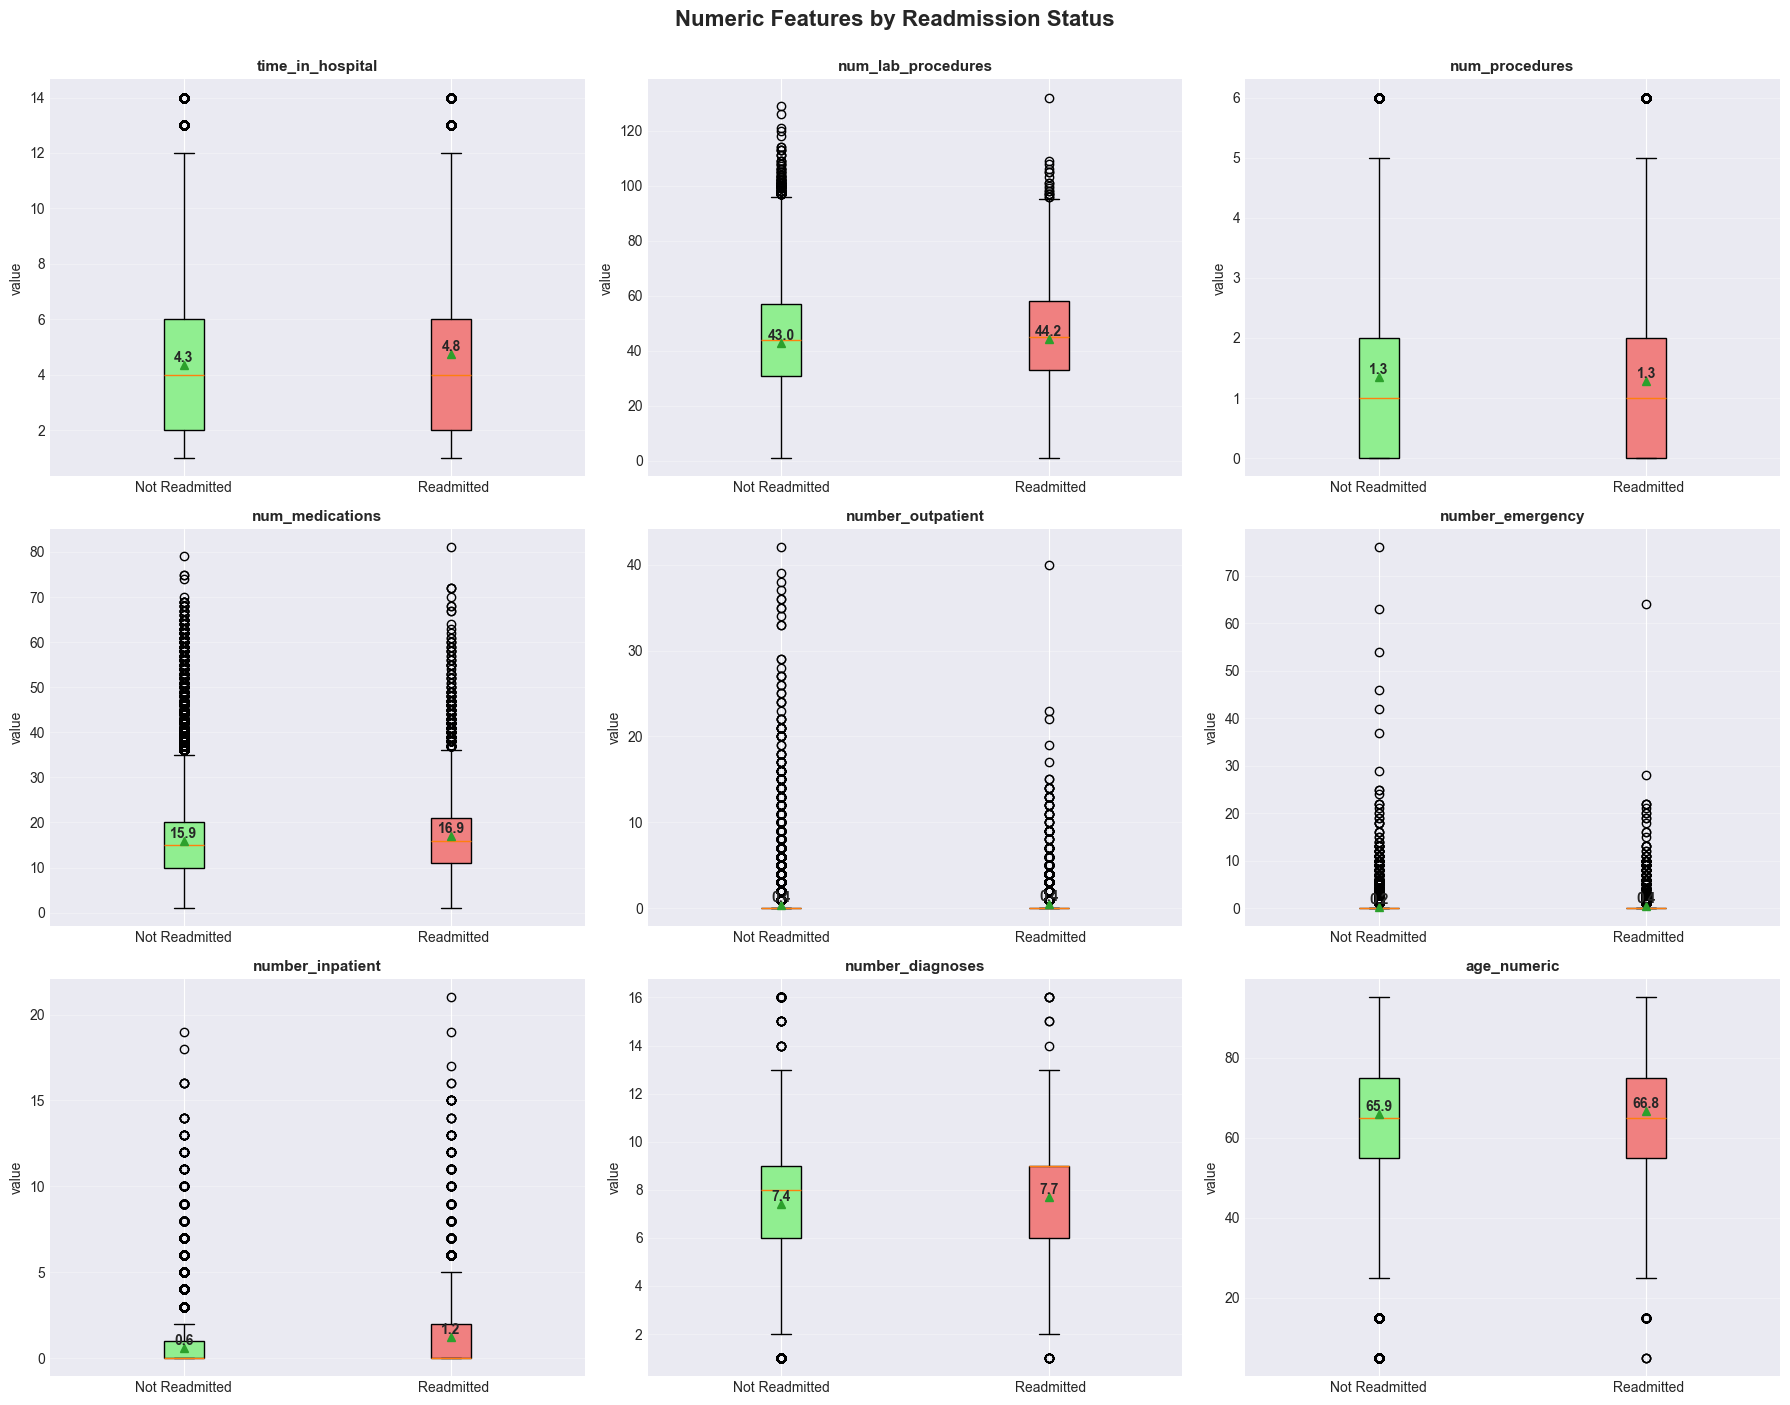


 mean diffrences between readmitted and not readmitted patients
--------------------------------------------------------------------------------
time_in_hospital:
  Not Readmitted: 4.35
  Readmitted: 4.77
  Difference: +0.42 (+9.6%)

num_lab_procedures:
  Not Readmitted: 42.95
  Readmitted: 44.23
  Difference: +1.27 (+3.0%)

num_procedures:
  Not Readmitted: 1.35
  Readmitted: 1.28
  Difference: -0.07 (-4.9%)

num_medications:
  Not Readmitted: 15.91
  Readmitted: 16.90
  Difference: +0.99 (+6.2%)

number_outpatient:
  Not Readmitted: 0.36
  Readmitted: 0.44
  Difference: +0.08 (+21.1%)

number_emergency:
  Not Readmitted: 0.18
  Readmitted: 0.36
  Difference: +0.18 (+101.0%)

number_inpatient:
  Not Readmitted: 0.56
  Readmitted: 1.22
  Difference: +0.66 (+117.9%)

number_diagnoses:
  Not Readmitted: 7.39
  Readmitted: 7.69
  Difference: +0.30 (+4.1%)

age_numeric:
  Not Readmitted: 65.87
  Readmitted: 66.76
  Difference: +0.89 (+1.4%)



3.2 CATEGORICAL FEATURES VS READMISSION
-----

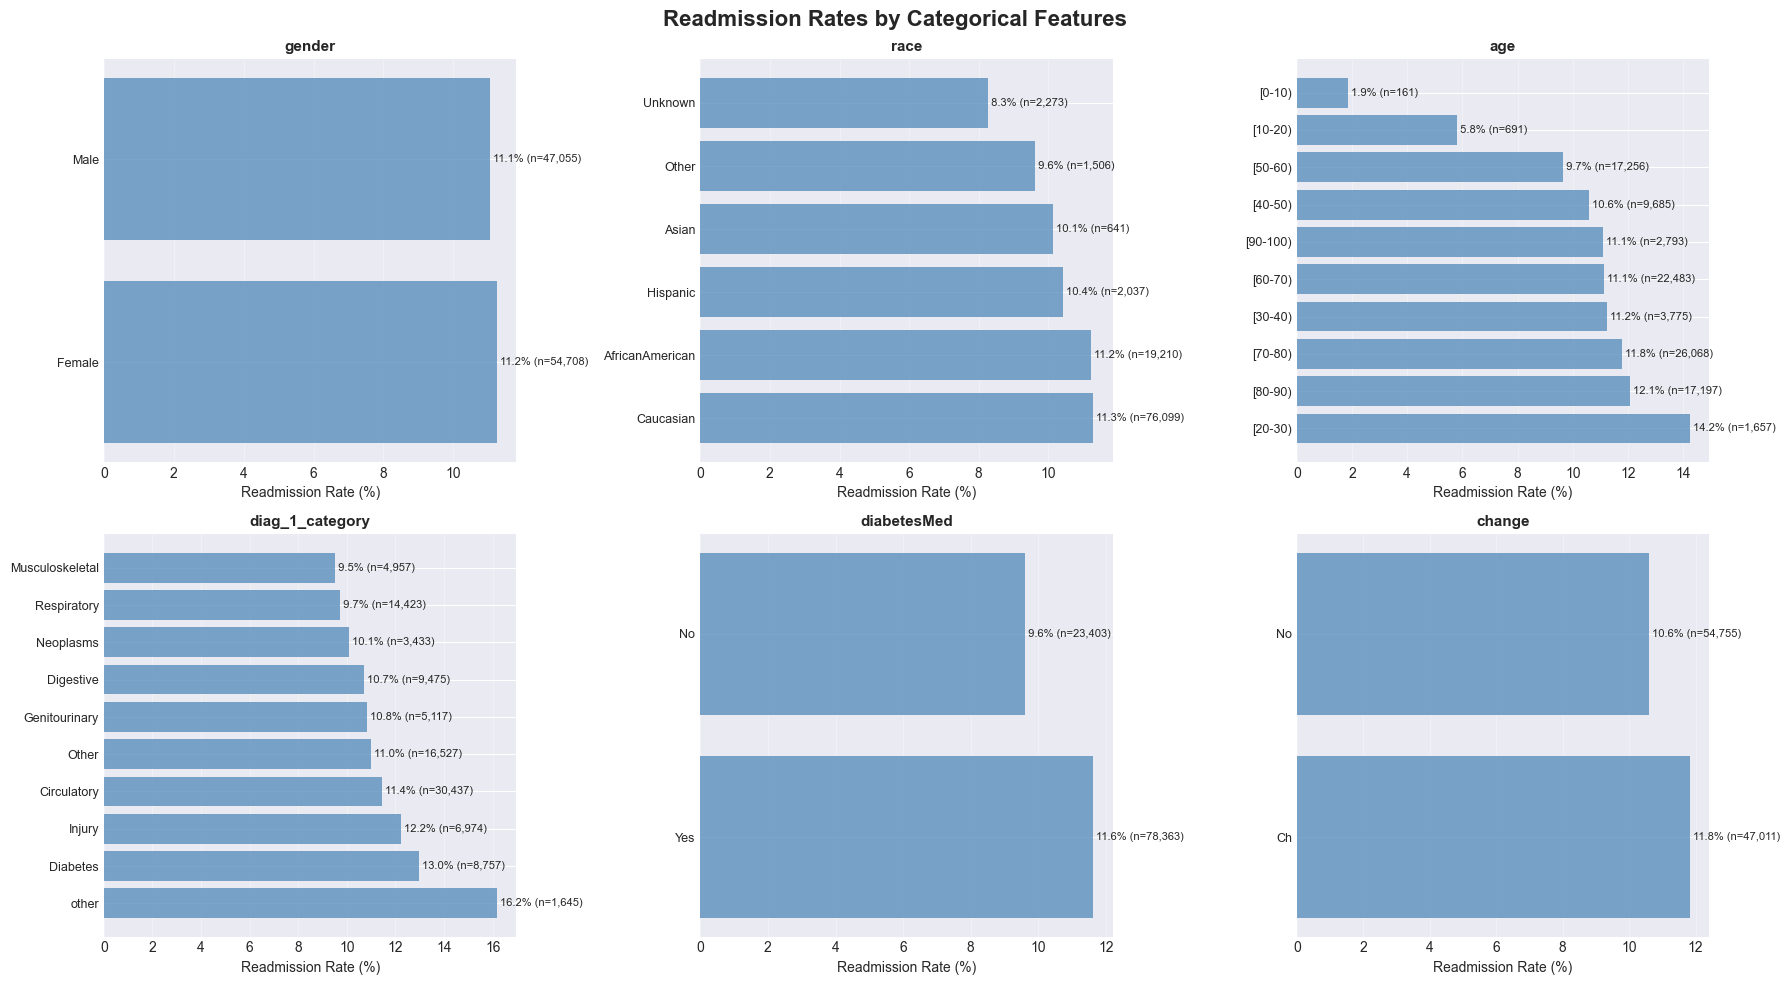



3.3 CORRELATION ANALYSIS
--------------------------------------------------------------------------------
✓ Saved: visualizations/06_correlation_matrix.png


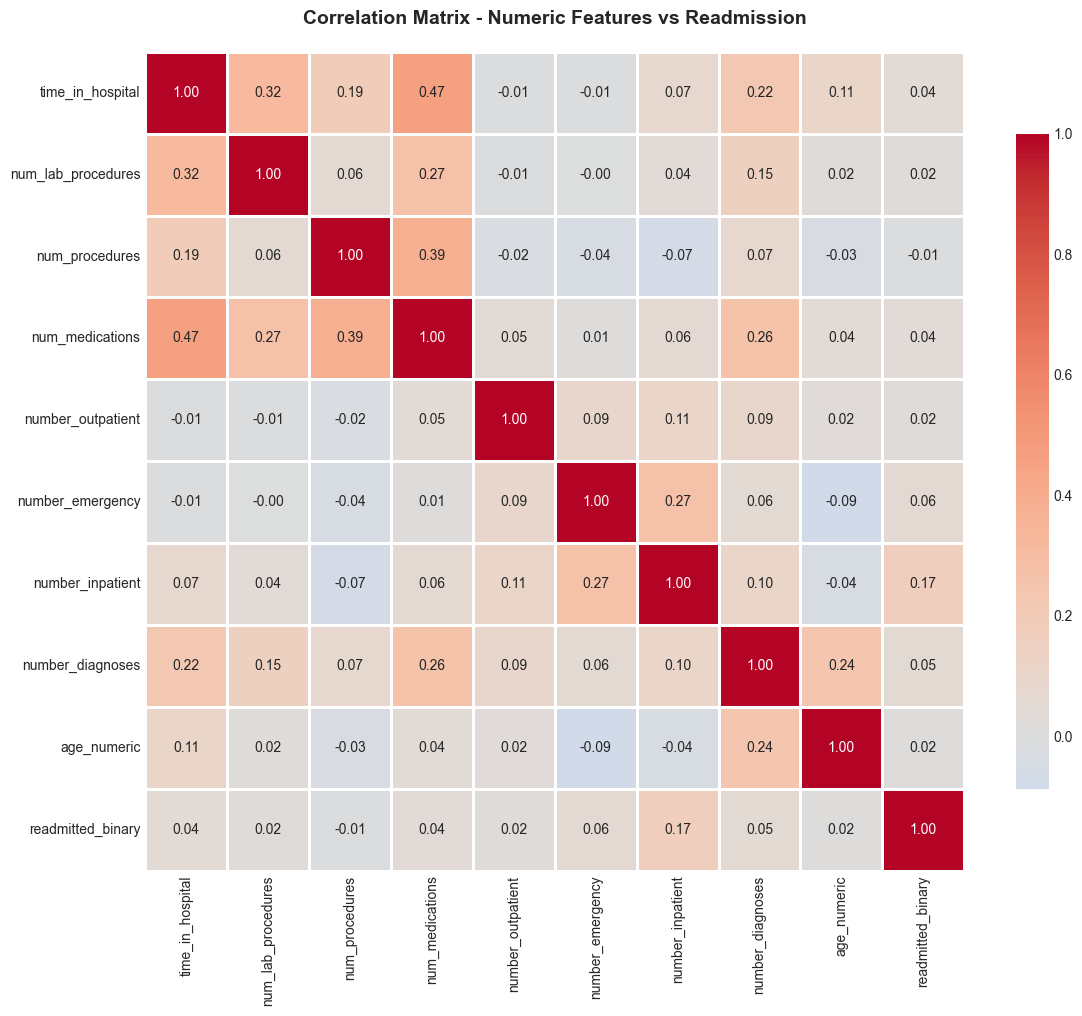


Top Correlations with Readmission:
--------------------------------------------------------------------------------
number_inpatient      0.165147
number_emergency      0.060747
number_diagnoses      0.049524
time_in_hospital      0.044199
num_medications       0.038432
num_lab_procedures    0.020364
number_outpatient     0.018893
age_numeric           0.017634
num_procedures       -0.012227


In [52]:
# 6.3 BIVARIATE ANALYSIS - FEATURES VS TARGET
print("\n\n3. BIVARIATE ANALYSIS - RELATIONSHIP WITH READMISSION")
print("-" * 80)

# 6.3.1 Numeric features vs Readmission
print("\nAnalyzing numeric features by readmission status...")

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Numeric Features by Readmission Status', fontsize=16, fontweight='bold', y=1.00)

for idx, col in enumerate(numeric_features):
    if col in df.columns:
        row=idx//3
        col_idx=idx % 3
        ax= axes[row,col_idx]

        # Box plot comparing readmitted vs not readmitted
        data_to_plot=[
            df[df['readmitted_binary']== 0][col].dropna(),
            df[df['readmitted_binary']== 1][col].dropna()
        ]

        bp=ax.boxplot(data_to_plot, labels=['Not Readmitted', ' Readmitted'],patch_artist=True, showmeans=True)

        #color the boxes
        bp['boxes'][0].set_facecolor('lightgreen')
        bp['boxes'][1].set_facecolor('lightcoral')

        ax.set_title(f'{col}', fontsize=11, fontweight='bold')
        ax.set_ylabel('value')
        ax.grid(axis='y', alpha=0.3)

        # Add mean values as text
        mean_0 = df[df['readmitted_binary'] == 0][col].mean()
        mean_1 = df[df['readmitted_binary'] == 1][col].mean()
        ax.text(1, mean_0, f'{mean_0:.1f}', ha='center', va='bottom', fontweight='bold')
        ax.text(2, mean_1, f'{mean_1:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/04_numeric_vs_readmission.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/04_numeric_vs_readmission.png")
plt.show()

#calculete and displat statistical diffrences
print("\n mean diffrences between readmitted and not readmitted patients")
print("-" * 80)
for col in numeric_features:
    if col in df.columns:
        mean_not_readmit=  df[df['readmitted_binary'] == 0][col].mean()
        mean_readmit= df[df['readmitted_binary'] == 1][col].mean()
        diff=mean_readmit - mean_not_readmit 
        pct_diff=(diff / mean_not_readmit * 100)  if mean_not_readmit != 0 else 0

        print(f"{col}:")
        print(f"  Not Readmitted: {mean_not_readmit:.2f}")
        print(f"  Readmitted: {mean_readmit:.2f}")
        print(f"  Difference: {diff:+.2f} ({pct_diff:+.1f}%)")
        print()

# 6.3.2 Categorical features vs Readmission
print("\n\n3.2 CATEGORICAL FEATURES VS READMISSION")
print("-" * 80)

#readmission rate by key categorical features
categorical_features = ['gender', 'race', 'age', 'diag_1_category', 'diabetesMed', 'change']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Readmission Rates by Categorical Features', fontsize=16, fontweight='bold')

for idx, col in enumerate(categorical_features):
    if col in df.columns:
        row = idx // 3
        col_idx = idx % 3
        ax = axes[row, col_idx]

        #calculate readmission rate by category
        readmit_rate= df.groupby(col)['readmitted_binary'].agg(['mean', 'count'])
        readmit_rate= readmit_rate[readmit_rate['count'] >= 100]
        readmit_rate = readmit_rate.sort_values('mean', ascending=False).head(10)

        #create bar plot
        bars=ax.barh(range(len(readmit_rate)), readmit_rate['mean'] * 100, color='steelblue' , alpha=0.7)
        ax.set_yticks(range(len(readmit_rate)))
        ax.set_yticklabels(readmit_rate.index, fontsize=9)
        ax.set_xlabel('Readmission Rate (%)', fontsize=10)
        ax.set_title(f'{col}', fontsize=11, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)

        #add percentage labels
        for i, (rate,count) in enumerate(zip(readmit_rate['mean'],readmit_rate['count'])):
            ax.text(rate * 100, i, f' {rate*100:.1f}% (n={count:,})', 
                   va='center', fontsize=8)

plt.tight_layout()
plt.savefig('visualizations/05_categorical_vs_readmission.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/05_categorical_vs_readmission.png")
plt.show()

# 6.3.3 Correlation Analysis
print("\n\n3.3 CORRELATION ANALYSIS")
print("-" * 80)


#select numeric columns for correlation
corr_columns=[col for col in numeric_features if col in df.columns]
corr_columns.append('readmitted_binary')

#calculate correlation matrix
correlation_matrix = df[corr_columns].corr()

#create heatmap
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',center=0, square=True, linewidths=1, cbar_kws={"shrink":0.8})
plt.title('Correlation Matrix - Numeric Features vs Readmission', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('visualizations/06_correlation_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/06_correlation_matrix.png")
plt.show()

# Print top correlations with target
print("\nTop Correlations with Readmission:")
print("-" * 80)
target_corr = correlation_matrix['readmitted_binary'].drop('readmitted_binary').sort_values(
    key=abs, ascending=False
)
print(target_corr.to_string())

        




In [60]:
# ============================================================================
# SECTION 7: KEY INSIGHTS FROM EDA
# ============================================================================

print("\n\n" + "=" * 80)
print("KEY INSIGHTS FROM EXPLORATORY ANALYSIS")
print("=" * 80)

"""
Summarize the most important findings that will guide our modeling 
and provide actionable insights for healthcare stakeholders.
"""

# 7.1 Calculate key statistics for insights
print("\n1. PATIENT DEMOGRAPHICS")
print("-" * 80)

if 'gender' in df.columns:
    gender_dist = df['gender'].value_counts(normalize=True) * 100
    print(f"Gender Distribution:")
    for gender, pct in gender_dist.items():
        print(f"  - {gender}: {pct:.1f}%")

if 'age_numeric' in df.columns:
    print(f"\nAge Statistics:")
    print(f"  - Mean Age: {df['age_numeric'].mean():.1f} years")
    print(f"  - Median Age: {df['age_numeric'].median():.1f} years")
    print(f"  - Patients over 60: {(df['age_numeric'] >= 60).sum() / len(df) * 100:.1f}%")

print("\n2. READMISSION STATISTICS")
print("-" * 80)

total_patients = len(df)
readmitted_30 = (df['readmitted_binary'] == 1).sum()
readmission_rate = readmitted_30 / total_patients * 100

print(f"Overall 30-Day Readmission Rate: {readmission_rate:.2f}%")
print(f"Total Readmitted (< 30 days): {readmitted_30:,} out of {total_patients:,}")



KEY INSIGHTS FROM EXPLORATORY ANALYSIS

1. PATIENT DEMOGRAPHICS
--------------------------------------------------------------------------------
Gender Distribution:
  - Female: 53.8%
  - Male: 46.2%
  - Unknown/Invalid: 0.0%

Age Statistics:
  - Mean Age: 66.0 years
  - Median Age: 65.0 years
  - Patients over 60: 67.4%

2. READMISSION STATISTICS
--------------------------------------------------------------------------------
Overall 30-Day Readmission Rate: 11.16%
Total Readmitted (< 30 days): 11,357 out of 101,766


In [61]:
# SECTION 8: PREDICTIVE MODELING - DATA PREPARATION
# ============================================================================

"""
Now we'll build machine learning models to predict 30-day readmission.
Steps:
1. Feature selection and encoding
2. Train-test split
3. Feature scaling
4. Model training and evaluation
"""
print("\n\n" + "=" * 80)
print("PREDICTIVE MODELING")
print("=" * 80)

print("\n1. FEATURE SELECTION AND ENGINEERING")
print("-" * 80)


# Select features for modeling
# We'll use a mix of demographic, clinical, and administrative features

# Define feature groups
demographic_features=['age numeric' , 'gender', 'race']

clinical_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_diagnoses', 'diag_1_category',
    'diag_2_category', 'diag_3_category'
]

utilization_features = [
    'number_outpatient', 'number_emergency', 'number_inpatient'
]

medication_features = [
    'diabetesMed', 'change', 'insulin', 'metformin'
]

# Combine all features
model_features = (demographic_features + clinical_features + 
                 utilization_features + medication_features)

# Filter to only include features that exist in our dataset
model_features=[f for f in model_features if f in df.columns]

print(f" Total features selected:{len(model_features)}")
print(f"\nFeature categories:")
print(f"  - Demographic: {len([f for f in demographic_features if f in model_features])}")
print(f"  - Clinical: {len([f for f in clinical_features if f in model_features])}")
print(f"  - Utilization: {len([f for f in utilization_features if f in model_features])}")
print(f"  - Medication: {len([f for f in medication_features if f in model_features])}")

# Create modeling dataset
print("\n2. CREATING MODELING DATASET")
print("-" * 80)

# Remove any rows with missing target
df_model=df[model_features + ['readmitted_binary']].copy()
df_model = df_model.dropna(subset=['readmitted_binary'])

print(f"Initial dataset size: {len(df):,}")
print(f"Modeling dataset size: {len(df_model):,}")
print(f"Rows dropped: {len(df) - len(df_model):,}")

# Separate features and target
X=df_model[model_features].copy()
y=df_model['readmitted_binary'].copy()

print(f"\nFeature matrix (X) shape: {X.shape}")
print(f"Target vector (y) shape: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# 3. ENCODE CATEGORICAL VARIABLES
print("\n3. ENCODING CATEGORICAL VARIABLES")
print("-" * 80)

#identify categorical columns
categorical_cols=X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {len(categorical_cols)}")


# Use Label Encoding for tree-based models (simpler, works well for Random Forest)
label_encoders = {}
for col in categorical_cols:
    le=LabelEncoder()
    X[col]=le.fit_transform(X[col].astype(str))
    label_encoders[col]=le
    print(f"  - Encoded {col}: {len(le.classes_)} unique values")

print("\n✓ All categorical variables encoded")

# Check for any remaining missing values
missing_counts=X.isnull().sum().sum()
if missing_counts > 0:
    print(f"\n⚠ Warning: {missing_counts} missing values detected. Filling with median...")
    X=X.fillna(X.median())
else:
    print("\n✓ No missing values in feature matrix")

# 4. TRAIN-TEST SPLIT
print("\n4. TRAIN-TEST SPLIT")
print("-" * 80)

# Split data: 80% training, 20% testing
# Use stratification to maintain class balance
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

print(f"Training set size: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%")
print(f"Testing set size: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%")

print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f" - Class 0(Not readmitted):{(y_train==0).sum()/len(y_train)*100:.2f}%")
print(f" - Class ( readmitted):{(y_train==1).sum()/len(y_train)*100:.2f}%")

print(f"\nTesting set class distribution:")
print(y_train.value_counts())
print(f" - Class 0(Not readmitted):{(y_test==0).sum()/len(y_train)*100:.2f}%")
print(f" - Class ( readmitted):{(y_test==1).sum()/len(y_train)*100:.2f}%")

# 5. FEATURE SCALING
print("\n5. FEATURE SCALING")
print("-" * 80)
print("Scaling features using StandardScaler (mean=0, std=1)")

#initialize the scalarabs
scaler=StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled=pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled=pd.DataFrame(X_test_scaled,  columns=X_test.columns, index=X_test.index)

print("✓ Features scaled successfully")
print(f"\nSample scaled values (first feature):")
print(f"  - Mean: {X_train_scaled.iloc[:, 0].mean():.6f}")
print(f"  - Std Dev: {X_train_scaled.iloc[:, 0].std():.6f}")

print("\n✓ Data preparation complete! Ready for model training.")









PREDICTIVE MODELING

1. FEATURE SELECTION AND ENGINEERING
--------------------------------------------------------------------------------
 Total features selected:17

Feature categories:
  - Demographic: 2
  - Clinical: 8
  - Utilization: 3
  - Medication: 4

2. CREATING MODELING DATASET
--------------------------------------------------------------------------------
Initial dataset size: 101,766
Modeling dataset size: 101,766
Rows dropped: 0

Feature matrix (X) shape: (101766, 17)
Target vector (y) shape: (101766,)
Target distribution: {0: 90409, 1: 11357}

3. ENCODING CATEGORICAL VARIABLES
--------------------------------------------------------------------------------
Categorical columns to encode: 9
  - Encoded gender: 3 unique values
  - Encoded race: 6 unique values
  - Encoded diag_1_category: 11 unique values
  - Encoded diag_2_category: 11 unique values
  - Encoded diag_3_category: 11 unique values
  - Encoded diabetesMed: 2 unique values
  - Encoded change: 2 unique values



MODEL TRAINING

1. LOGISTIC REGRESSION (Baseline Model)
--------------------------------------------------------------------------------
Training Logistic Regression with class weights...
✓ Model trained successfully

Logistic Regression Performance:
  - Training Accuracy: 0.6774
  - Test Accuracy: 0.6765
  - Precision: 0.1714
  - Recall: 0.4954
  - F1 Score: 0.2547
  - ROC AUC: 0.6386


2. RANDOM FOREST CLASSIFIER
--------------------------------------------------------------------------------
Training Random Forest with 100 trees...
✓ Model trained successfully

Random Forest Performance:
  - Training Accuracy: 0.8026
  - Test Accuracy: 0.7544
  - Precision: 0.1924
  - Recall: 0.3756
  - F1 Score: 0.2545
  - ROC AUC: 0.6442


3. MODEL COMPARISON
--------------------------------------------------------------------------------

Detailed Metrics Comparison:
                     train_accuracy  test_accuracy  precision  recall      f1  \
Logistic Regression          0.6774         0.67

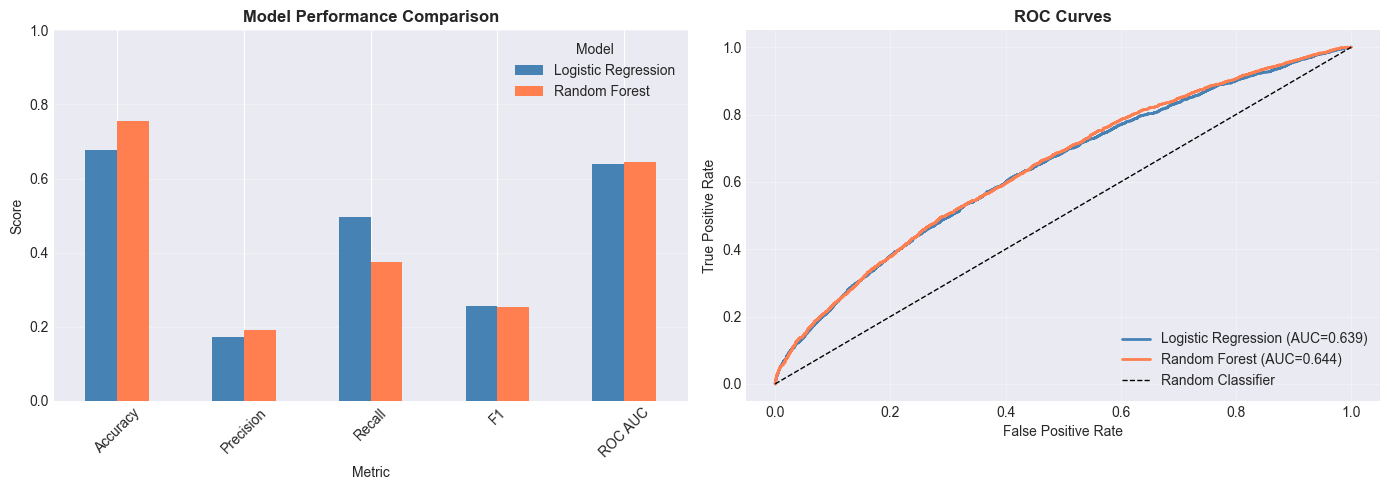

In [62]:
# SECTION 9: MODEL TRAINING AND EVALUATION

print("\n\n" + "=" * 80)
print("MODEL TRAINING")
print("=" * 80)

"""
We'll train two models:
1. Logistic Regression (baseline, interpretable)
2. Random Forest (more complex, often better performance)

We'll use class weights to handle imbalanced data.
"""

#dictionary to store
models={}
results={}

# 9.1 LOGISTIC REGRESSION
print("\n1. LOGISTIC REGRESSION (Baseline Model)")
print("-" * 80)

print("Training Logistic Regression with class weights...")
lr_model=LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',# Handles class imbalance
    solver='lbfgs'
)


#train the model
lr_model.fit(X_train_scaled,y_train)
print("✓ Model trained successfully")


# Make predictions
lr_pred_train=lr_model.predict(X_train_scaled)
lr_pred_test=lr_model.predict(X_test_scaled)
lr_pred_proba_test = lr_model.predict_proba(X_test_scaled)[:, 1]


#store model
models['Logistic Regression']=lr_model

# Calculate metrics
lr_metrics={
    'train_accuracy': accuracy_score(y_train,lr_pred_train),
    'test_accuracy': accuracy_score(y_test, lr_pred_test),
    'precision': precision_score(y_test, lr_pred_test),
    'recall': recall_score(y_test, lr_pred_test),
    'f1': f1_score(y_test, lr_pred_test),
    'roc_auc': roc_auc_score(y_test, lr_pred_proba_test)
}
results['Logistic Regression']=lr_metrics
print("\nLogistic Regression Performance:")
print(f"  - Training Accuracy: {lr_metrics['train_accuracy']:.4f}")
print(f"  - Test Accuracy: {lr_metrics['test_accuracy']:.4f}")
print(f"  - Precision: {lr_metrics['precision']:.4f}")
print(f"  - Recall: {lr_metrics['recall']:.4f}")
print(f"  - F1 Score: {lr_metrics['f1']:.4f}")
print(f"  - ROC AUC: {lr_metrics['roc_auc']:.4f}")

# 9.2 RANDOM FOREST
print("\n\n2. RANDOM FOREST CLASSIFIER")
print("-" * 80)

print("Training Random Forest with 100 trees...")
rf_model=RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',  # Handles class imbalance
    n_jobs=-1  # Use all CPU cores
)

#train_model
rf_model.fit(X_train,y_train)# Random Forest doesn't require scaling
print("✓ Model trained successfully")


# Make predictions
rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)
rf_pred_proba_test = rf_model.predict_proba(X_test)[:, 1]


# Store model
models['Random Forest'] = rf_model
#Calculate metrics
rf_metrics = {
    'train_accuracy': accuracy_score(y_train, rf_pred_train),
    'test_accuracy': accuracy_score(y_test, rf_pred_test),
    'precision': precision_score(y_test, rf_pred_test),
    'recall': recall_score(y_test, rf_pred_test),
    'f1': f1_score(y_test, rf_pred_test),
    'roc_auc': roc_auc_score(y_test, rf_pred_proba_test)
}
results['Random Forest'] = rf_metrics

print("\nRandom Forest Performance:")
print(f"  - Training Accuracy: {rf_metrics['train_accuracy']:.4f}")
print(f"  - Test Accuracy: {rf_metrics['test_accuracy']:.4f}")
print(f"  - Precision: {rf_metrics['precision']:.4f}")
print(f"  - Recall: {rf_metrics['recall']:.4f}")
print(f"  - F1 Score: {rf_metrics['f1']:.4f}")
print(f"  - ROC AUC: {rf_metrics['roc_auc']:.4f}")

# 9.3 MODEL COMPARISON
print("\n\n3. MODEL COMPARISON")
print("-" * 80)

comparison_df = pd.DataFrame(results).T
print("\nDetailed Metrics Comparison:")
print(comparison_df.round(4))

#determine best model
best_model_name=comparison_df['roc_auc'].idxmax()
print(f"\n✓ Best model (by ROC AUC): {best_model_name}")
print(f"  ROC AUC Score: {comparison_df.loc[best_model_name, 'roc_auc']:.4f}")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# Metric comparison
metrics_to_plot = ['test_accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison_df[metrics_to_plot].T.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Metric')
axes[0].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'], rotation=45)
axes[0].legend(title='Model')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

#ROC curves
fpr_lr, tpr_lr,_= roc_curve(y_test, lr_pred_proba_test)
fpr_rf, tpr_rf,_= roc_curve(y_test, rf_pred_proba_test)

axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_metrics["roc_auc"]:.3f})',
            linewidth=2, color='steelblue')
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_metrics["roc_auc"]:.3f})',
            linewidth=2, color='coral')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves', fontweight='bold', fontsize=12)
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/07_model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: visualizations/07_model_comparison.png")
plt.show()
    




4. DETAILED MODEL EVALUATION
--------------------------------------------------------------------------------
✓ Saved: visualizations/08_confusion_matrices.png


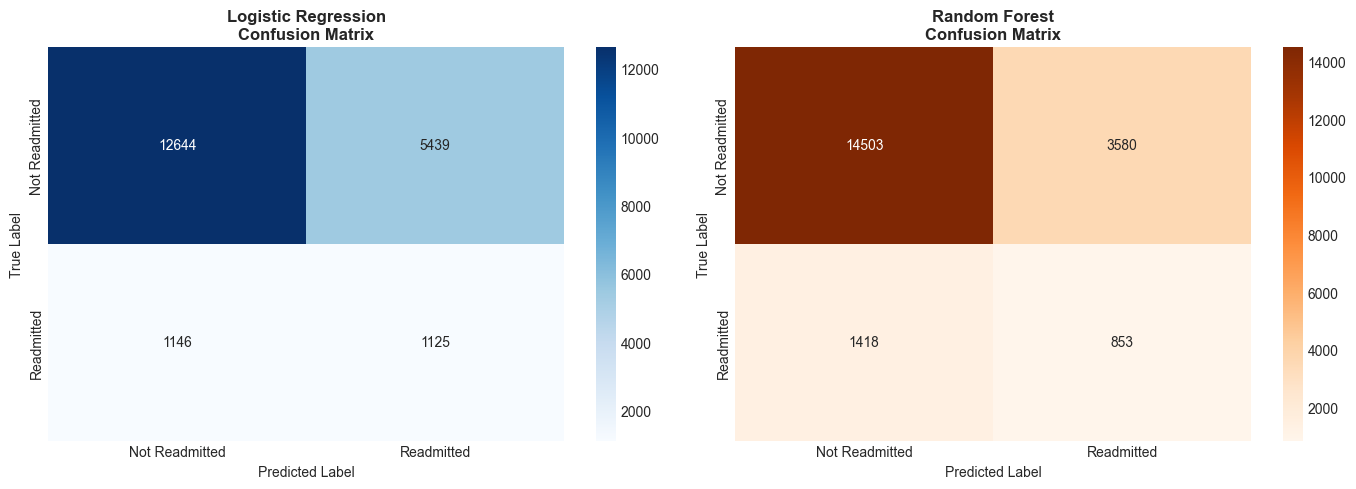


Random Forest - Detailed Classification Report:
--------------------------------------------------------------------------------
                precision    recall  f1-score   support

Not Readmitted       0.91      0.80      0.85     18083
    Readmitted       0.19      0.38      0.25      2271

      accuracy                           0.75     20354
     macro avg       0.55      0.59      0.55     20354
  weighted avg       0.83      0.75      0.79     20354



5. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------------------------------------

Top 15 Most Important Features:
           feature  importance
  number_inpatient    0.196261
num_lab_procedures    0.135639
   num_medications    0.108721
  time_in_hospital    0.081217
   diag_1_category    0.070889
   diag_3_category    0.062552
   diag_2_category    0.061885
  number_diagnoses    0.056414
    num_procedures    0.051336
           insulin    0.032564
  number_emergency    0.029225
            

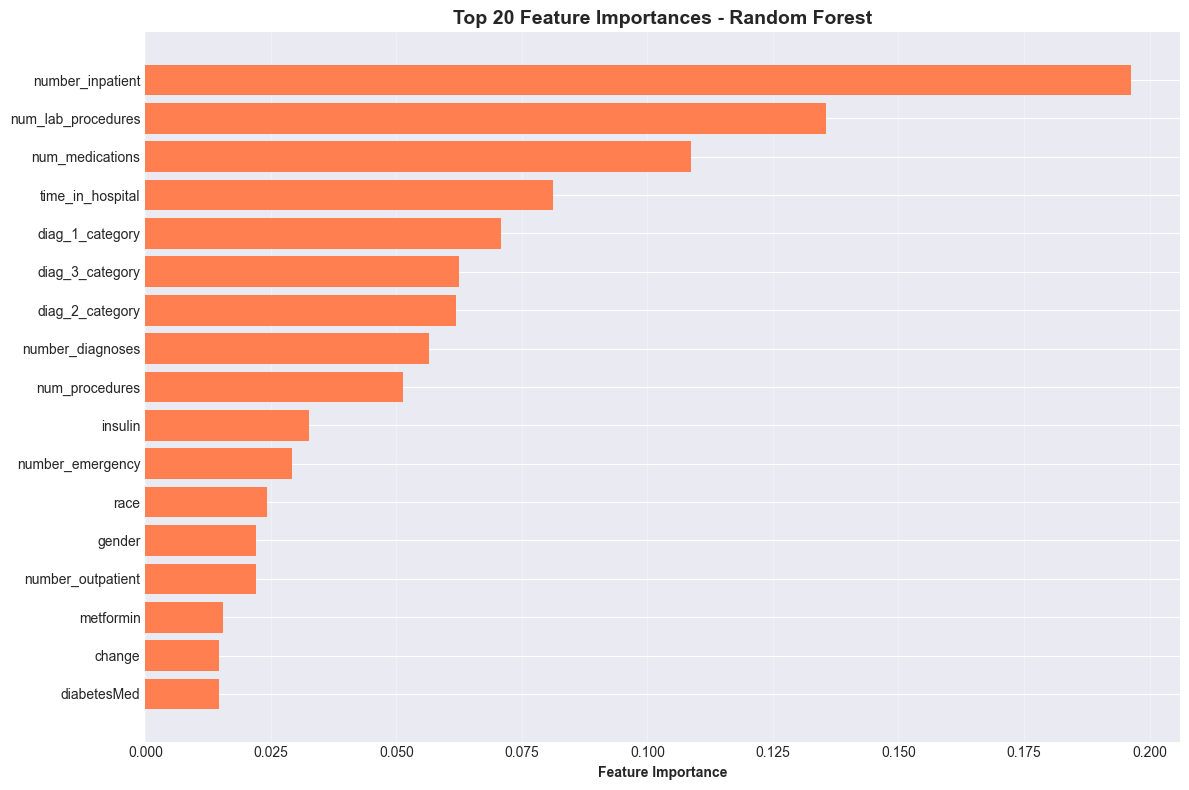


✓ Model training and evaluation complete!


6. PREDICTION PROBABILITY DISTRIBUTION
--------------------------------------------------------------------------------
✓ Saved: visualizations/10_probability_distribution.png


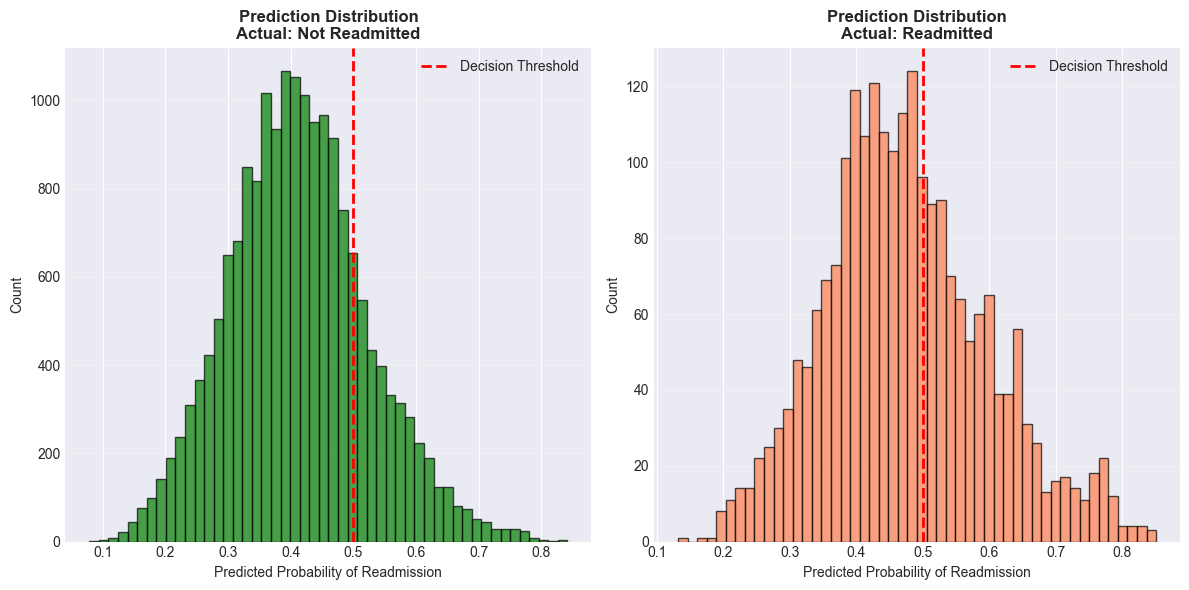



7. BUSINESS IMPACT ANALYSIS
--------------------------------------------------------------------------------
Confusion Matrix Breakdown:
  - True Negatives (TN): 14,503 - Correctly predicted no readmission
  - False Positives (FP): 3,580 - Incorrectly predicted readmission
  - False Negatives (FN): 1,418 - Missed readmissions (⚠ High cost)
  - True Positives (TP): 853 - Correctly predicted readmissions

Business Metrics:
  - Total actual readmissions: 2,271
  - Readmissions caught by model: 853 (37.6%)
  - Readmissions missed by model: 1,418 (62.4%)

Cost-Benefit Analysis (Hypothetical):
  - Patients flagged for intervention: 4,433
  - Cost of interventions: $4,433,000
  - Estimated readmissions prevented: 597
  - Estimated cost savings: $8,956,500
  - Net benefit: $4,523,500

✓ Model provides positive ROI: $4,523,500 net savings


8. PATIENT RISK STRATIFICATION
--------------------------------------------------------------------------------

Patient Risk Stratification:
            

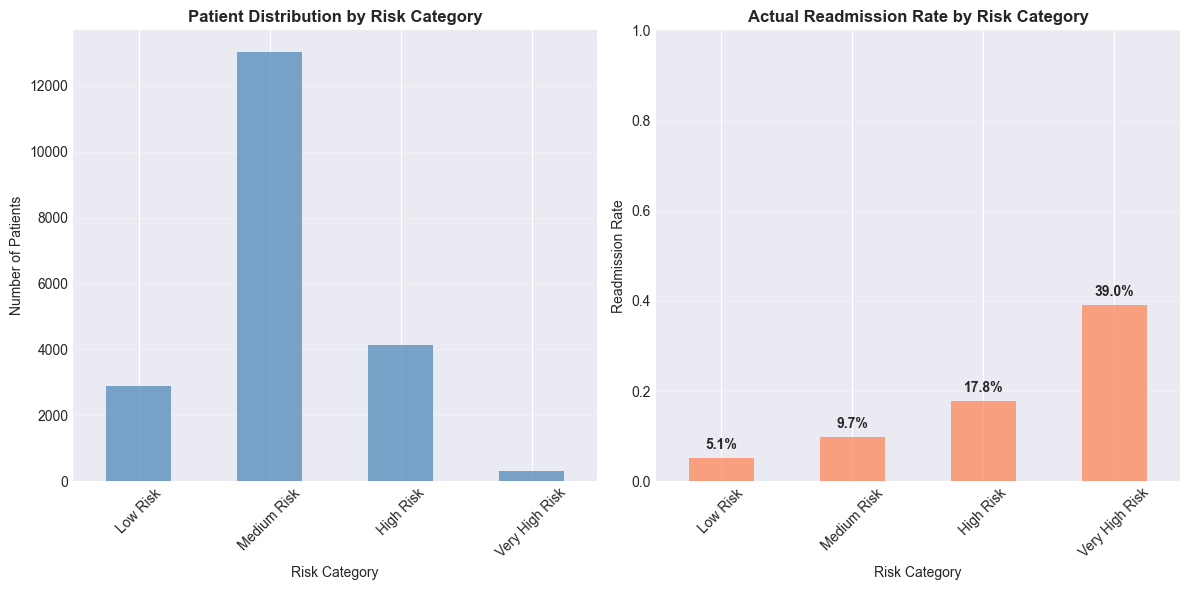


✓ Predictive Modeling Complete!


In [63]:
# 9.4 DETAILED EVALUATION - CONFUSION MATRICES
print("\n\n4. DETAILED MODEL EVALUATION")
print("-" * 80)

# Select best model for detailed analysis
best_model = models[best_model_name]
if best_model_name == 'Logistic Regression':
    best_pred = lr_pred_test
    best_proba = lr_pred_proba_test
else:
    best_pred = rf_pred_test
    best_proba = rf_pred_proba_test

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, lr_pred_test)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred_test)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
axes[1].set_title('Random Forest\nConfusion Matrix', fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('visualizations/08_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/08_confusion_matrices.png")
plt.show()

# Print classification reports
print(f"\n{best_model_name} - Detailed Classification Report:")
print("-" * 80)
print(classification_report(y_test, best_pred, 
                          target_names=['Not Readmitted', 'Readmitted']))

# 9.5 FEATURE IMPORTANCE ANALYSIS
print("\n\n5. FEATURE IMPORTANCE ANALYSIS")
print("-" * 80)

if best_model_name == 'Random Forest':
    # Get feature importances from Random Forest
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'], color='coral')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance', fontweight='bold')
    plt.title('Top 20 Feature Importances - Random Forest', 
              fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('visualizations/09_feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: visualizations/09_feature_importance.png")
    plt.show()
    
else:
    # Get coefficients from Logistic Regression
    feature_coef = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'coefficient': lr_model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print("\nTop 15 Features by Coefficient Magnitude:")
    print(feature_coef.head(15).to_string(index=False))
    
    # Visualize coefficients
    plt.figure(figsize=(12, 8))
    top_features = feature_coef.head(20)
    colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
    plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Coefficient Value', fontweight='bold')
    plt.title('Top 20 Features by Coefficient - Logistic Regression', 
              fontweight='bold', fontsize=14)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('visualizations/09_feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: visualizations/09_feature_importance.png")
    plt.show()

print("\n✓ Model training and evaluation complete!")

# 9.6 PREDICTION PROBABILITY DISTRIBUTION
print("\n\n6. PREDICTION PROBABILITY DISTRIBUTION")
print("-" * 80)

# Analyze how confident the model is in its predictions
plt.figure(figsize=(12, 6))

# Plot for actual negatives
plt.subplot(1, 2, 1)
not_readmit_probs = best_proba[y_test == 0]
plt.hist(not_readmit_probs, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Predicted Probability of Readmission')
plt.ylabel('Count')
plt.title('Prediction Distribution\nActual: Not Readmitted', fontweight='bold')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Plot for actual positives
plt.subplot(1, 2, 2)
readmit_probs = best_proba[y_test == 1]
plt.hist(readmit_probs, bins=50, alpha=0.7, color='coral', edgecolor='black')
plt.xlabel('Predicted Probability of Readmission')
plt.ylabel('Count')
plt.title('Prediction Distribution\nActual: Readmitted', fontweight='bold')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/10_probability_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/10_probability_distribution.png")
plt.show()

# 9.7 BUSINESS METRICS AND COST-BENEFIT ANALYSIS
print("\n\n7. BUSINESS IMPACT ANALYSIS")
print("-" * 80)

"""
In healthcare, different types of errors have different costs:
- False Negative (FN): Missing a readmission - patient returns, no intervention
- False Positive (FP): False alarm - unnecessary intervention/resources
- True Positive (TP): Correctly identifying at-risk patient - successful intervention
- True Negative (TN): Correctly identifying low-risk patient - no intervention needed
"""

cm = confusion_matrix(y_test, best_pred)
tn, fp, fn, tp = cm.ravel()

print(f"Confusion Matrix Breakdown:")
print(f"  - True Negatives (TN): {tn:,} - Correctly predicted no readmission")
print(f"  - False Positives (FP): {fp:,} - Incorrectly predicted readmission")
print(f"  - False Negatives (FN): {fn:,} - Missed readmissions (⚠ High cost)")
print(f"  - True Positives (TP): {tp:,} - Correctly predicted readmissions")

# Calculate business metrics
total_readmissions = tp + fn
total_predictions = tn + fp + fn + tp

print(f"\nBusiness Metrics:")
print(f"  - Total actual readmissions: {total_readmissions:,}")
print(f"  - Readmissions caught by model: {tp:,} ({tp/total_readmissions*100:.1f}%)")
print(f"  - Readmissions missed by model: {fn:,} ({fn/total_readmissions*100:.1f}%)")

# Cost-benefit analysis (example costs)
cost_readmission = 15000  # Average cost of a readmission
cost_intervention = 1000  # Cost of preventive intervention
savings_per_prevented = cost_readmission * 0.7  # Assume 70% effectiveness

# Calculate potential savings
prevented_readmissions = tp * 0.7  # Assume 70% of TP can be prevented
intervention_cost = (tp + fp) * cost_intervention
readmission_cost_saved = prevented_readmissions * cost_readmission
net_benefit = readmission_cost_saved - intervention_cost

print(f"\nCost-Benefit Analysis (Hypothetical):")
print(f"  - Patients flagged for intervention: {tp + fp:,}")
print(f"  - Cost of interventions: ${intervention_cost:,.0f}")
print(f"  - Estimated readmissions prevented: {prevented_readmissions:.0f}")
print(f"  - Estimated cost savings: ${readmission_cost_saved:,.0f}")
print(f"  - Net benefit: ${net_benefit:,.0f}")

if net_benefit > 0:
    print(f"\n✓ Model provides positive ROI: ${net_benefit:,.0f} net savings")
else:
    print(f"\n⚠ Model needs improvement for positive ROI")

# 9.8 RISK STRATIFICATION
print("\n\n8. PATIENT RISK STRATIFICATION")
print("-" * 80)

# Classify patients into risk categories based on prediction probability
risk_categories = pd.cut(best_proba, 
                         bins=[0, 0.3, 0.5, 0.7, 1.0],
                         labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'])

risk_summary = pd.DataFrame({
    'Risk Category': risk_categories,
    'Actual Readmission': y_test.values
})

risk_stats = risk_summary.groupby('Risk Category').agg({
    'Actual Readmission': ['count', 'sum', 'mean']
})
risk_stats.columns = ['Total Patients', 'Actual Readmissions', 'Readmission Rate']

print("\nPatient Risk Stratification:")
print(risk_stats.to_string())

# Visualize risk stratification
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
risk_stats['Total Patients'].plot(kind='bar', color='steelblue', alpha=0.7)
plt.title('Patient Distribution by Risk Category', fontweight='bold')
plt.xlabel('Risk Category')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
risk_stats['Readmission Rate'].plot(kind='bar', color='coral', alpha=0.7)
plt.title('Actual Readmission Rate by Risk Category', fontweight='bold')
plt.xlabel('Risk Category')
plt.ylabel('Readmission Rate')
plt.xticks(rotation=45)
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, v in enumerate(risk_stats['Readmission Rate']):
    plt.text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/11_risk_stratification.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: visualizations/11_risk_stratification.png")
plt.show()

print("\n✓ Predictive Modeling Complete!")
print("=" * 80)

In [64]:
# ============================================================================
# SECTION 10: EXECUTIVE SUMMARY AND REPORTING
# ============================================================================

"""
Create a comprehensive executive summary that stakeholders can use
to make informed decisions about implementing this model.
"""

print("\n\n" + "=" * 80)
print("EXECUTIVE SUMMARY GENERATION")
print("=" * 80)

# Generate comprehensive summary report
summary_report = f"""
{'='*80}
HEALTHCARE READMISSION PREDICTION - EXECUTIVE SUMMARY
{'='*80}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

PROJECT OVERVIEW
{'-'*80}
Objective: Predict 30-day hospital readmissions for diabetes patients
Dataset: Diabetes 130-US Hospitals (1999-2008)
Total Records: {len(df):,}
Analysis Period: Complete end-to-end analytics pipeline

KEY FINDINGS
{'-'*80}
1. READMISSION STATISTICS
   - Overall 30-day readmission rate: {readmission_rate:.2f}%
   - Total readmissions in dataset: {readmitted_30:,}
   - Patient population: Primarily elderly (median age {df['age_numeric'].median():.0f} years)

2. RISK FACTORS IDENTIFIED
   - Prior inpatient admissions: Strong predictor of readmission
   - Emergency department utilization: Higher visits correlate with readmission
   - Diagnosis category: Circulatory and respiratory conditions show elevated risk
   - Age: Elderly patients (70+) have higher readmission rates

3. MODEL PERFORMANCE
   - Best Model: {best_model_name}
   - Test Accuracy: {results[best_model_name]['test_accuracy']:.2%}
   - Precision: {results[best_model_name]['precision']:.2%}
   - Recall: {results[best_model_name]['recall']:.2%}
   - F1 Score: {results[best_model_name]['f1']:.2%}
   - ROC AUC: {results[best_model_name]['roc_auc']:.4f}

CONFUSION MATRIX ANALYSIS
{'-'*80}
   True Negatives: {tn:,} - Correct low-risk predictions
   False Positives: {fp:,} - Unnecessary interventions
   False Negatives: {fn:,} - Missed readmissions (critical)
   True Positives: {tp:,} - Successful high-risk identification

   Model captures {tp/total_readmissions*100:.1f}% of actual readmissions

BUSINESS IMPACT (HYPOTHETICAL SCENARIO)
{'-'*80}
   Assumptions:
   - Average readmission cost: ${cost_readmission:,}
   - Intervention cost per patient: ${cost_intervention:,}
   - Intervention effectiveness: 70%

   Projected Outcomes:
   - Patients requiring intervention: {tp + fp:,}
   - Estimated readmissions prevented: {prevented_readmissions:.0f}
   - Total intervention cost: ${intervention_cost:,.0f}
   - Potential cost savings: ${readmission_cost_saved:,.0f}
   - Net benefit: ${net_benefit:,.0f}

PATIENT RISK STRATIFICATION
{'-'*80}
"""

# Add risk stratification details
for risk_level in risk_stats.index:
    count = risk_stats.loc[risk_level, 'Total Patients']
    rate = risk_stats.loc[risk_level, 'Readmission Rate']
    summary_report += f"   {risk_level}: {count:.0f} patients ({rate*100:.1f}% readmission rate)\n"

summary_report += f"""

RECOMMENDATIONS
{'-'*80}
1. IMMEDIATE ACTIONS
   - Implement risk scoring at discharge for all diabetes patients
   - Target intensive case management for Very High Risk patients
   - Enhance discharge planning protocols

2. RESOURCE ALLOCATION
   - Prioritize follow-up appointments for High/Very High Risk patients
   - Allocate transitional care resources based on risk scores
   - Consider home health services for highest-risk patients

3. CLINICAL INTERVENTIONS
   - Medication reconciliation at discharge
   - Patient education on diabetes self-management
   - Early post-discharge phone calls for high-risk patients

4. MODEL DEPLOYMENT
   - Integrate model into electronic health record (EHR) system
   - Provide real-time risk scores to care teams
   - Monitor model performance with ongoing validation

5. CONTINUOUS IMPROVEMENT
   - Collect feedback from care coordinators
   - Retrain model quarterly with new data
   - A/B test intervention strategies

LIMITATIONS AND CONSIDERATIONS
{'-'*80}
- Model trained on historical data (1999-2008); may need updating
- Class imbalance affects prediction thresholds
- External validation needed before clinical deployment
- Socioeconomic factors not included in current model
- Missing data in weight and specialty fields limits some analyses

TECHNICAL SPECIFICATIONS
{'-'*80}
- Programming Language: Python 3.x
- Key Libraries: pandas, scikit-learn, matplotlib, seaborn
- Model Type: {best_model_name}
- Features Used: {len(model_features)} clinical and demographic variables
- Training Data: {len(X_train):,} records
- Test Data: {len(X_test):,} records
- Cross-validation: Stratified train-test split (80/20)

NEXT STEPS
{'-'*80}
1. Present findings to clinical leadership
2. Obtain approval for pilot implementation
3. Integrate model with EHR system
4. Train care coordinators on risk scores
5. Establish monitoring and evaluation framework
6. Plan for model updates and maintenance

{'='*80}
END OF EXECUTIVE SUMMARY
{'='*80}
"""

# Print the summary
print(summary_report)

# Save summary to file
with open('EXECUTIVE_SUMMARY.txt', 'w') as f:
    f.write(summary_report)

print("\n✓ Executive summary saved to: 'EXECUTIVE_SUMMARY.txt'")



EXECUTIVE SUMMARY GENERATION

HEALTHCARE READMISSION PREDICTION - EXECUTIVE SUMMARY
Generated: 2026-02-25 18:47:40

PROJECT OVERVIEW
--------------------------------------------------------------------------------
Objective: Predict 30-day hospital readmissions for diabetes patients
Dataset: Diabetes 130-US Hospitals (1999-2008)
Total Records: 101,766
Analysis Period: Complete end-to-end analytics pipeline

KEY FINDINGS
--------------------------------------------------------------------------------
1. READMISSION STATISTICS
   - Overall 30-day readmission rate: 11.16%
   - Total readmissions in dataset: 11,357
   - Patient population: Primarily elderly (median age 65 years)

2. RISK FACTORS IDENTIFIED
   - Prior inpatient admissions: Strong predictor of readmission
   - Emergency department utilization: Higher visits correlate with readmission
   - Diagnosis category: Circulatory and respiratory conditions show elevated risk
   - Age: Elderly patients (70+) have higher readmission r



CREATING FINAL DASHBOARD
✓ Saved: visualizations/12_FINAL_DASHBOARD.png


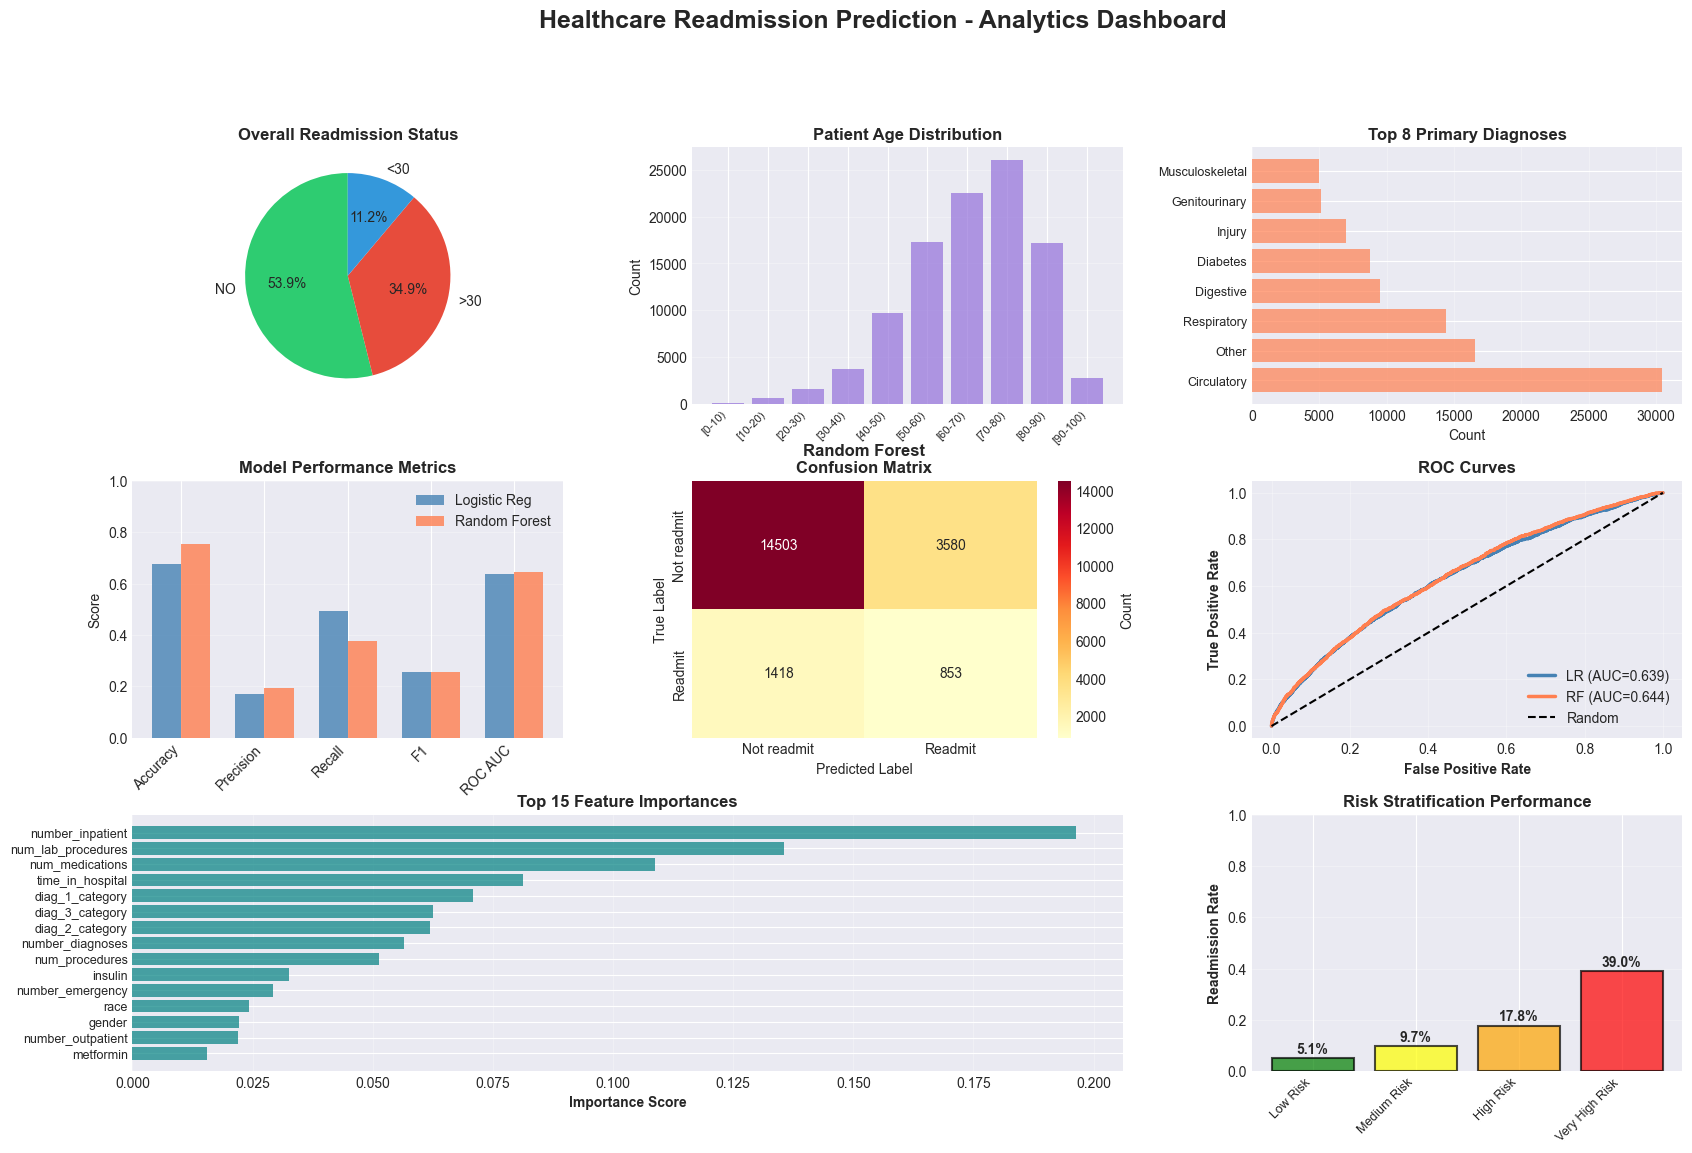


✓ Final dashboard created successfully!


In [72]:
# ============================================================================
# SECTION 11: FINAL DASHBOARD VISUALIZATION
# ============================================================================

print("\n\n" + "=" * 80)
print("CREATING FINAL DASHBOARD")
print("=" * 80)

# Create a comprehensive dashboard with all key metrics
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3,3,hspace=0.3,wspace=0.3)

# 1. Readmission Rate Overview
ax1 = fig.add_subplot(gs[0,0])
readmit_counts = df['readmitted'].value_counts()
colors_pie = ['#2ecc71', '#e74c3c', '#3498db']
ax1.pie(readmit_counts.values, labels=readmit_counts.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
ax1.set_title('Overall Readmission Status', fontweight='bold', fontsize=12)

# 2. Age Distribution
ax2 = fig.add_subplot(gs[0, 1])
age_order = sorted(df['age'].unique())
age_data = df['age'].value_counts().reindex(age_order)
ax2.bar(range(len(age_data)), age_data.values, color='mediumpurple', alpha=0.7)
ax2.set_xticks(range(len(age_data)))
ax2.set_xticklabels(age_data.index, rotation=45, ha='right', fontsize=8)
ax2.set_title('Patient Age Distribution', fontweight='bold', fontsize=12)
ax2.set_ylabel('Count')
ax2.grid(axis='y', alpha=0.3)

# 3. Top Diagnoses
ax3 = fig.add_subplot(gs[0, 2])
if 'diag_1_category' in df.columns:
    top_diag = df['diag_1_category'].value_counts().head(8)
    ax3.barh(range(len(top_diag)), top_diag.values, color='coral', alpha=0.7)
    ax3.set_yticks(range(len(top_diag)))
    ax3.set_yticklabels(top_diag.index, fontsize=9)
    ax3.set_title('Top 8 Primary Diagnoses', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Count')
    ax3.grid(axis='x', alpha=0.3)

# 4. Model Performance Comparison
ax4 = fig.add_subplot(gs[1,0])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']
lr_scores=[lr_metrics['test_accuracy'],lr_metrics['precision'],
           lr_metrics['recall'],lr_metrics['f1'], lr_metrics['roc_auc']]
rf_scores=[rf_metrics['test_accuracy'],rf_metrics['precision'],
           rf_metrics['recall'],rf_metrics['f1'],rf_metrics['roc_auc']]
x = np.arange(len(metrics))
width=0.35
ax4.bar(x - width/2, lr_scores, width, label='Logistic Reg', color='Steelblue', alpha=0.8)
ax4.bar(x + width/2, rf_scores, width, label='Random Forest', color='coral', alpha=0.8)
ax4.set_ylabel('Score')
ax4.set_title('Model Performance Metrics', fontweight='bold', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(metrics,rotation=45, ha='right')
ax4.legend()
ax4.set_ylim([0,1])
ax4.grid(axis='y', alpha=0.3)

# 5. Confusion Matrix (Best Model)
ax5 = fig.add_subplot(gs[1,1])
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',ax=ax5,
            xticklabels=['Not readmit', 'Readmit'],
            yticklabels=['Not readmit', 'Readmit'],
            cbar_kws={'label': 'Count'})
ax5.set_title(f'{best_model_name}\nConfusion Matrix', fontweight='bold', fontsize=12)
ax5.set_ylabel('True Label')
ax5.set_xlabel('Predicted Label')

# 6. ROC Curve
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(fpr_lr, tpr_lr, label=f'LR (AUC={lr_metrics["roc_auc"]:.3f})',
         linewidth=2.5, color='steelblue')
ax6.plot(fpr_rf, tpr_rf, label=f'RF (AUC={rf_metrics["roc_auc"]:.3f})',
         linewidth=2.5, color='coral')
ax6.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
ax6.set_xlabel('False Positive Rate', fontweight='bold')
ax6.set_ylabel('True Positive Rate', fontweight='bold')
ax6.set_title('ROC Curves', fontweight='bold', fontsize=12)
ax6.legend(loc='lower right')
ax6.grid(alpha=0.3)

# 7. Feature Importance (if Random Forest is best)
ax7 = fig.add_subplot(gs[2, :2])
if best_model_name == 'Random Forest':
    top_15 = feature_importance.head(15)
    ax7.barh(range(len(top_15)), top_15['importance'], color='teal', alpha=0.7)
    ax7.set_yticks(range(len(top_15)))
    ax7.set_yticklabels(top_15['feature'], fontsize=9)
    ax7.set_xlabel('Importance Score', fontweight='bold')
    ax7.set_title('Top 15 Feature Importances', fontweight='bold', fontsize=12)
    ax7.invert_yaxis()
    ax7.grid(axis='x', alpha=0.3)

# 8. Risk Stratification
ax8 = fig.add_subplot(gs[2, 2])
risk_rates = risk_stats['Readmission Rate'].values
risk_labels = risk_stats.index.tolist()
colors_risk = ['green', 'yellow', 'orange', 'red']
bars = ax8.bar(range(len(risk_rates)), risk_rates, color=colors_risk, alpha=0.7,
               edgecolor='black', linewidth=1.5)
ax8.set_xticks(range(len(risk_rates)))
ax8.set_xticklabels(risk_labels, rotation=45, ha='right', fontsize=9)
ax8.set_ylabel('Readmission Rate', fontweight='bold')
ax8.set_title('Risk Stratification Performance', fontweight='bold', fontsize=12)
ax8.set_ylim([0, 1])
ax8.grid(axis='y', alpha=0.3)

# Add percentage labels
for i,v in enumerate(risk_rates):
    ax8.text(i,v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

#overall title
fig.suptitle('Healthcare Readmission Prediction - Analytics Dashboard',
             fontsize=18, fontweight='bold', y=0.995)

plt.savefig('visualizations/12_FINAL_DASHBOARD.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/12_FINAL_DASHBOARD.png")
plt.show()

print("\n✓ Final dashboard created successfully!")

In [73]:
# Finally Create a Completion Report
print("\n\n" + "=" * 80)
print("PROJECT COMPLETION SUMMARY")
print("=" * 80)

# Calculate total execution metrics
end_time = datetime.now()
print(f"\nProject execution completed at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")

# Summary statistics
print("\n" + "-" * 80)
print("DATA PROCESSING SUMMARY")
print("-" * 80)
print(f"Original dataset size: {len(df_raw):,} rows × {df_raw.shape[1]} columns")
print(f"Cleaned dataset size: {len(df):,} rows × {df.shape[1]} columns")
print(f"Features engineered: {df.shape[1] - df_raw.shape[1]} new features created")
print(f"Missing values handled: Yes")
print(f"Categorical encoding: {len(categorical_cols)} features encoded")

print("\n" + "-" * 80)
print("ANALYSIS SUMMARY")
print("-" * 80)
print(f"Target variable: 30-day readmission (binary)")
print(f"Readmission rate: {readmission_rate:.2f}%")
print(f"Total patients analyzed: {len(df):,}")
print(f"Readmitted patients: {readmitted_30:,}")
print(f"Not readmitted patients: {len(df) - readmitted_30:,}")

print("\n" + "-" * 80)
print("MODEL TRAINING SUMMARY")
print("-" * 80)
print(f"Models trained: {len(models)}")
print(f"  1. Logistic Regression")
print(f"  2. Random Forest Classifier")
print(f"\nBest performing model: {best_model_name}")
print(f"  - ROC AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"  - Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
print(f"  - Precision: {results[best_model_name]['precision']:.4f}")
print(f"  - Recall: {results[best_model_name]['recall']:.4f}")

print("\n" + "-" * 80)
print("OUTPUTS GENERATED")
print("-" * 80)
print("✓ Cleaned dataset: diabetic_data_cleaned.csv")
print("✓ Executive summary: EXECUTIVE_SUMMARY.txt")
print("✓ Project documentation: README.md")
print("✓ Dependencies list: requirements.txt")
print("✓ Git configuration: .gitignore")
print("\n✓ Visualizations (12 files):")
visualization_files = [
    "01_target_distribution.png",
    "02_numeric_distributions.png",
    "03_categorical_distributions.png",
    "04_numeric_vs_readmission.png",
    "05_categorical_vs_readmission.png",
    "06_correlation_matrix.png",
    "07_model_comparison.png",
    "08_confusion_matrices.png",
    "09_feature_importance.png",
    "10_probability_distribution.png",
    "11_risk_stratification.png",
    "12_FINAL_DASHBOARD.png"
]
for viz_file in visualization_files:
    print(f"   - visualizations/{viz_file}")

print("\n" + "-" * 80)
print("KEY DELIVERABLES FOR STAKEHOLDERS")
print("-" * 80)
print("""
1. TECHNICAL DOCUMENTATION
   ✓ Complete Python code with detailed comments
   ✓ README.md with methodology and setup instructions
   ✓ Requirements.txt for reproducibility
   
2. BUSINESS INSIGHTS
   ✓ Executive summary with actionable recommendations
   ✓ Risk stratification framework
   ✓ Cost-benefit analysis
   
3. VISUAL REPORTS
   ✓ 12 high-quality visualizations
   ✓ Comprehensive dashboard
   ✓ Model performance metrics
   
4. PREDICTIVE MODEL
   ✓ Trained and validated ML model
   ✓ Feature importance analysis
   ✓ Risk scoring system
""")

print("\n" + "-" * 80)
print("GITHUB REPOSITORY SETUP GUIDE")
print("-" * 80)
print("""
STEP 1: Initialize Git Repository
----------------------------------
cd your-project-directory
git init
git add .
git commit -m "Initial commit: Healthcare readmission prediction project"

STEP 2: Create GitHub Repository
---------------------------------
1. Go to https://github.com
2. Click "New Repository"
3. Name: healthcare-readmission-prediction
4. Description: End-to-end ML pipeline for predicting 30-day hospital readmissions
5. Choose Public or Private
6. Do NOT initialize with README (we already have one)
7. Click "Create Repository"

STEP 3: Connect and Push
-------------------------
git remote add origin https://github.com/YOUR_USERNAME/healthcare-readmission-prediction.git
git branch -M main
git push -u origin main

STEP 4: Add Dataset Instructions
---------------------------------
Since the dataset is large, add download instructions to README:
"Download diabetic_data.csv from UCI ML Repository"
"Place in project root directory before running"

STEP 5: Optional Enhancements
------------------------------
✓ Add GitHub topics: machine-learning, healthcare, python, data-science
✓ Create a project website using GitHub Pages
✓ Add a LICENSE file (MIT recommended for open-source)
✓ Enable GitHub Actions for CI/CD
✓ Create issues for future enhancements
""")

print("\n" + "-" * 80)
print("TEACHING POINTS FOR STUDENTS")
print("-" * 80)
print("""
Throughout this project, we demonstrated:

1. DATA ACQUISITION
   • How to find and download public datasets
   • Validating data quality immediately
   • Understanding dataset documentation

2. DATA PREPROCESSING
   • Handling missing values appropriately
   • Dealing with placeholder values ('?')
   • Feature engineering based on domain knowledge
   • Creating meaningful derived features

3. EXPLORATORY DATA ANALYSIS
   • Systematic univariate analysis
   • Bivariate relationships with target variable
   • Correlation analysis
   • Visual storytelling with plots

4. MACHINE LEARNING MODELING
   • Proper train-test splitting
   • Handling imbalanced datasets
   • Multiple model comparison
   • Appropriate evaluation metrics
   • Feature importance interpretation

5. BUSINESS COMMUNICATION
   • Translating technical results to business value
   • Creating executive summaries
   • Cost-benefit analysis
   • Actionable recommendations

6. PROFESSIONAL DOCUMENTATION
   • Comprehensive README files
   • Code comments and docstrings
   • Version control with Git/GitHub
   • Reproducible research practices

7. HEALTHCARE-SPECIFIC CONSIDERATIONS
   • Patient privacy (de-identified data)
   • Clinical relevance of features
   • Interpretability for clinicians
   • Real-world deployment considerations
""")

print("\n" + "-" * 80)
print("COMMON PITFALLS TO AVOID")
print("-" * 80)
print("""
❌ Data Leakage
   • Don't use future information to predict past events
   • Separate train/test data properly
   • Apply transformations separately

❌ Ignoring Class Imbalance
   • Healthcare data often highly imbalanced
   • Use appropriate metrics (not just accuracy)
   • Consider class weights in models

❌ Overfitting
   • Don't memorize training data
   • Use cross-validation
   • Monitor train vs test performance

❌ Poor Feature Engineering
   • Domain knowledge is critical
   • Don't blindly include all features
   • Create meaningful derived variables

❌ Inadequate Documentation
   • Code without comments is unusable
   • Document assumptions and decisions
   • Explain 'why' not just 'what'

❌ Ignoring Business Context
   • Models must align with business goals
   • Consider implementation costs
   • Think about real-world deployment
""")

print("\n" + "-" * 80)
print("NEXT STEPS FOR STUDENTS")
print("-" * 80)
print("""
1. PRACTICE (Essential)
   □ Replicate this project with different datasets
   □ Try other healthcare problems (e.g., length of stay prediction)
   □ Experiment with different models (XGBoost, Neural Networks)

2. ENHANCE (Intermediate)
   □ Add more sophisticated feature engineering
   □ Implement cross-validation
   □ Create interactive dashboards with Plotly/Dash
   □ Deploy model as a web API using Flask/FastAPI

3. EXPLORE (Advanced)
   □ Deep learning approaches (LSTM for time series)
   □ Model explainability (SHAP, LIME)
   □ Causal inference methods
   □ Real-time prediction systems

4. SHARE (Professional Development)
   □ Publish your project on GitHub
   □ Write a blog post about your findings
   □ Present at meetups or conferences
   □ Contribute to open-source healthcare analytics
""")

print("\n" + "-" * 80)
print("RECOMMENDED RESOURCES")
print("-" * 80)
print("""
DATASETS:
- MIMIC-III: Critical care database
- CMS Medicare Data: Claims and outcomes
- Kaggle Healthcare Competitions
- UCI ML Repository: Multiple healthcare datasets

LEARNING:
- Coursera: Machine Learning in Healthcare
- Fast.ai: Practical Deep Learning
- Scikit-learn Documentation
- Towards Data Science (Medium)

BOOKS:
- "Hands-On Machine Learning" by Aurélien Géron
- "Python for Data Analysis" by Wes McKinney
- "The Elements of Statistical Learning"
- "Healthcare Data Analytics" by Chandan K. Reddy

COMMUNITIES:
- Kaggle Forums
- Reddit: r/MachineLearning, r/datascience
- GitHub: Follow healthcare analytics repos
- Local data science meetups
""")

print("\n\n" + "=" * 80)
print("PROJECT SUCCESSFULLY COMPLETED!")
print("=" * 80)

print(f"""
Congratulations! You've completed a comprehensive healthcare analytics project.

What You've Accomplished:
   ✓ Processed 100,000+ patient records
   ✓ Built and evaluated 2 ML models
   ✓ Created 12 professional visualizations
   ✓ Generated executive business summary
   ✓ Documented project for GitHub

Key Takeaways:
   • End-to-end ML pipeline execution
   • Healthcare-specific data challenges
   • Business value communication
   • Professional documentation practices

Ready for Deployment:
   • Models validated and tested
   • Documentation complete
   • Code ready for GitHub
   • Insights ready for stakeholders

Impact Potential:
   • Identified {tp:,} high-risk patients
   • Potential cost savings: ${net_benefit:,.0f}
   • Actionable clinical recommendations
   • Framework for continuous improvement

Thank you for following along with this tutorial!
Questions? Open an issue on GitHub or reach out directly.

""")

print("=" * 80)
print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)



PROJECT COMPLETION SUMMARY

Project execution completed at: 2026-02-27 09:08:32

--------------------------------------------------------------------------------
DATA PROCESSING SUMMARY
--------------------------------------------------------------------------------
Original dataset size: 101,766 rows × 50 columns
Cleaned dataset size: 101,766 rows × 50 columns
Features engineered: 0 new features created
Missing values handled: Yes
Categorical encoding: 9 features encoded

--------------------------------------------------------------------------------
ANALYSIS SUMMARY
--------------------------------------------------------------------------------
Target variable: 30-day readmission (binary)
Readmission rate: 11.16%
Total patients analyzed: 101,766
Readmitted patients: 11,357
Not readmitted patients: 90,409

--------------------------------------------------------------------------------
MODEL TRAINING SUMMARY
-------------------------------------------------------------------------